# Signal optimization basics

## Get packages and JPMaQS data

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, VotingClassifier

from sklearn.metrics import (
    make_scorer,
    balanced_accuracy_score,
    r2_score,
    matthews_corrcoef
)
import scipy.stats as stats
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
print(str(Path.cwd().parent))
import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
from macrosynergy.download import JPMaQSDownload

import warnings

np.random.seed(42)
random.seed(42)

warnings.simplefilter("ignore")

macrosynergy_fixed_income_returns_and_macro_trends_path = './kaggle'

print('Data source path:', macrosynergy_fixed_income_returns_and_macro_trends_path)
df = pd.read_csv(macrosynergy_fixed_income_returns_and_macro_trends_path + '\JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])
display (df.head(3))
df.info()

c:\finance\macrosynergy
Data source path: ./kaggle


real_date  cid              xcat     value  grading  eop_lag  mop_lag
0 2000-01-03  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     95.0    292.0
1 2000-01-04  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     96.0    293.0
2 2000-01-05  AUD  CPIC_SA_P1M1ML12  1.244168      2.0     97.0    294.0

<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 206.9+ MB


In [7]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = sorted(cids_dm + cids_em)
cids_dux = sorted(list(set(cids) - set(["IDR", "INR", "NZD", "TRY"])))

In [8]:
# Quantamental categories of interest

main = [
    "RYLDIRS05Y_NSA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "INFTEFF_NSA",
    "PCREDITBN_SJA_P1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
]

mkts = [
    "DU05YXR_VT10",
    "FXTARGETED_NSA", 
    "FXUNTRADABLE_NSA"
]


xcats = main + mkts

In [9]:
# Resultant tickers for download

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + [
    "USD_DU05YXR_NSA",
    "USD_GB10YXR_NSA",
]

In [10]:

dfx = df.copy()
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 206.9+ MB


## Availability and blacklisting

In [11]:
msm.missing_in_df(df, xcats=xcats, cids=cids)

No missing XCATs across DataFrame.
Missing cids for CPIC_SJA_P6M6ML6AR:            []
Missing cids for CPIH_SA_P1M1ML12:              []
Missing cids for DU05YXR_VT10:                  []
Missing cids for FXTARGETED_NSA:                ['USD']
Missing cids for FXUNTRADABLE_NSA:              ['USD']
Missing cids for INFTEFF_NSA:                   []
Missing cids for INTRGDPv5Y_NSA_P1M1ML12_3MMA:  []
Missing cids for PCREDITBN_SJA_P1M1ML12:        []
Missing cids for RGDP_SA_P1Q1QL4_20QMA:         []
Missing cids for RYLDIRS05Y_NSA:                []


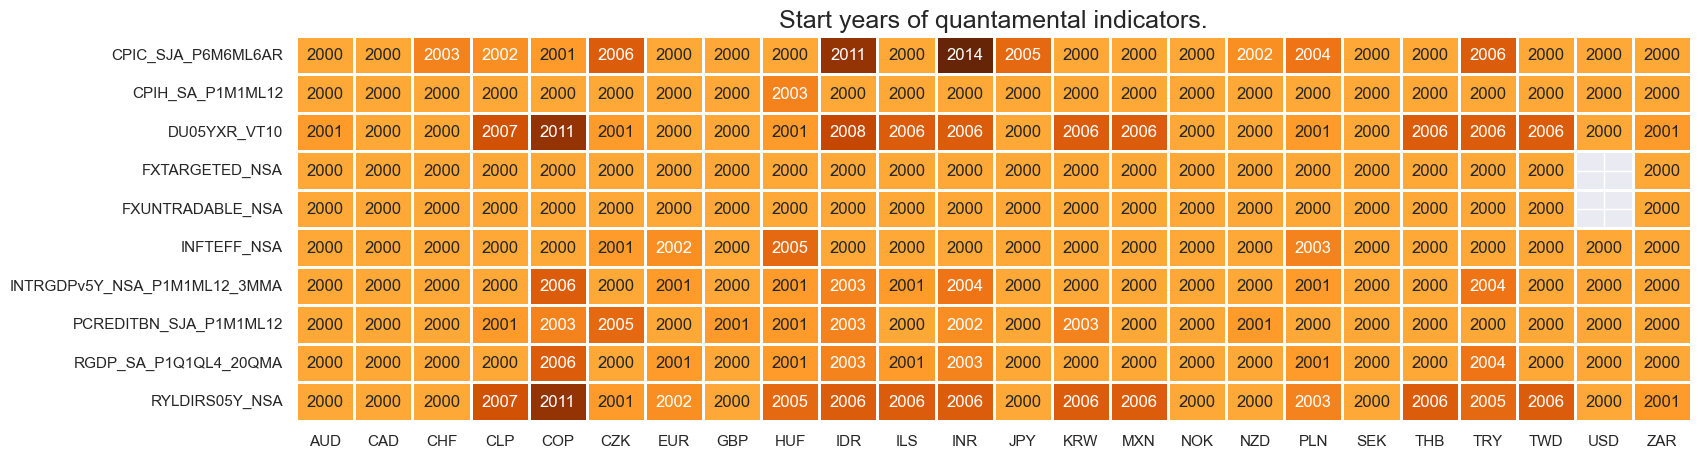

In [12]:
msm.check_availability(df=dfx, xcats=xcats, cids=cids, missing_recent=False)

In [13]:
# Create blacklisting dictionary

dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'CHF': (Timestamp('2011-10-03 00:00:00'), Timestamp('2015-01-30 00:00:00')),
 'CZK': (Timestamp('2014-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 'ILS': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-12-30 00:00:00')),
 'INR': (Timestamp('2000-01-03 00:00:00'), Timestamp('2004-12-31 00:00:00')),
 'THB': (Timestamp('2007-01-01 00:00:00'), Timestamp('2008-11-28 00:00:00')),
 'TRY_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2003-09-30 00:00:00')),
 'TRY_2': (Timestamp('2020-01-01 00:00:00'), Timestamp('2023-12-13 00:00:00'))}

## Transformation and checks

### Signal constituent candidates

In [14]:
calcs = [
    "XGDP_NEG = - INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "XCPI_NEG =  - ( CPIC_SJA_P6M6ML6AR + CPIH_SA_P1M1ML12 ) / 2 + INFTEFF_NSA",
    "XPCG_NEG = - PCREDITBN_SJA_P1M1ML12 + INFTEFF_NSA + RGDP_SA_P1Q1QL4_20QMA",
    "XRYLDIRS05Y_NSA = RYLDIRS05Y_NSA",
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

Add noise features

In [15]:
xcatx = ["NOISE1", "NOISE2", "NOISE3", "NOISE4"]

df_cids = pd.DataFrame(index=cids, columns=['earliest', 'latest', 'mean_add','sd_mult'])

for cid in cids:
    df_cids.loc[cid] = [start_date, pd.Timestamp.today().date(), 0, 1]
    
df_xcats = pd.DataFrame(
    index=xcatx,
    columns=['earliest', 'latest', 'mean_add','sd_mult', 'ar_coef', 'back_coef'],
)

for xcat in xcatx:
    df_xcats.loc[xcat] = [start_date, pd.Timestamp.today().date(), 0, 1, 1, 0]
    
dfa = msm.make_qdf(df_cids, df_xcats)
dfx = msm.update_df(dfx, dfa)

### Individual and average z-scores

In [16]:
macros = [
    "XGDP_NEG",
    "XCPI_NEG",
    "XPCG_NEG",
    "XRYLDIRS05Y_NSA",
    "NOISE1",
    "NOISE2",
    "NOISE3",
    "NOISE4",
]
xcatx = macros

for xc in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cids,
        neutral="zero",
        thresh=3,
        est_freq="M",
        pan_weight=1,
        postfix="_ZN",
    )
    dfx = msm.update_df(dfx, dfa)

dfa = msp.linear_composite(
    df=dfx,
    xcats=[xc + "_ZN" for xc in xcatx],
    cids=cids,
    new_xcat="MACRO_AVGZ",
)

dfx = msm.update_df(dfx, dfa)

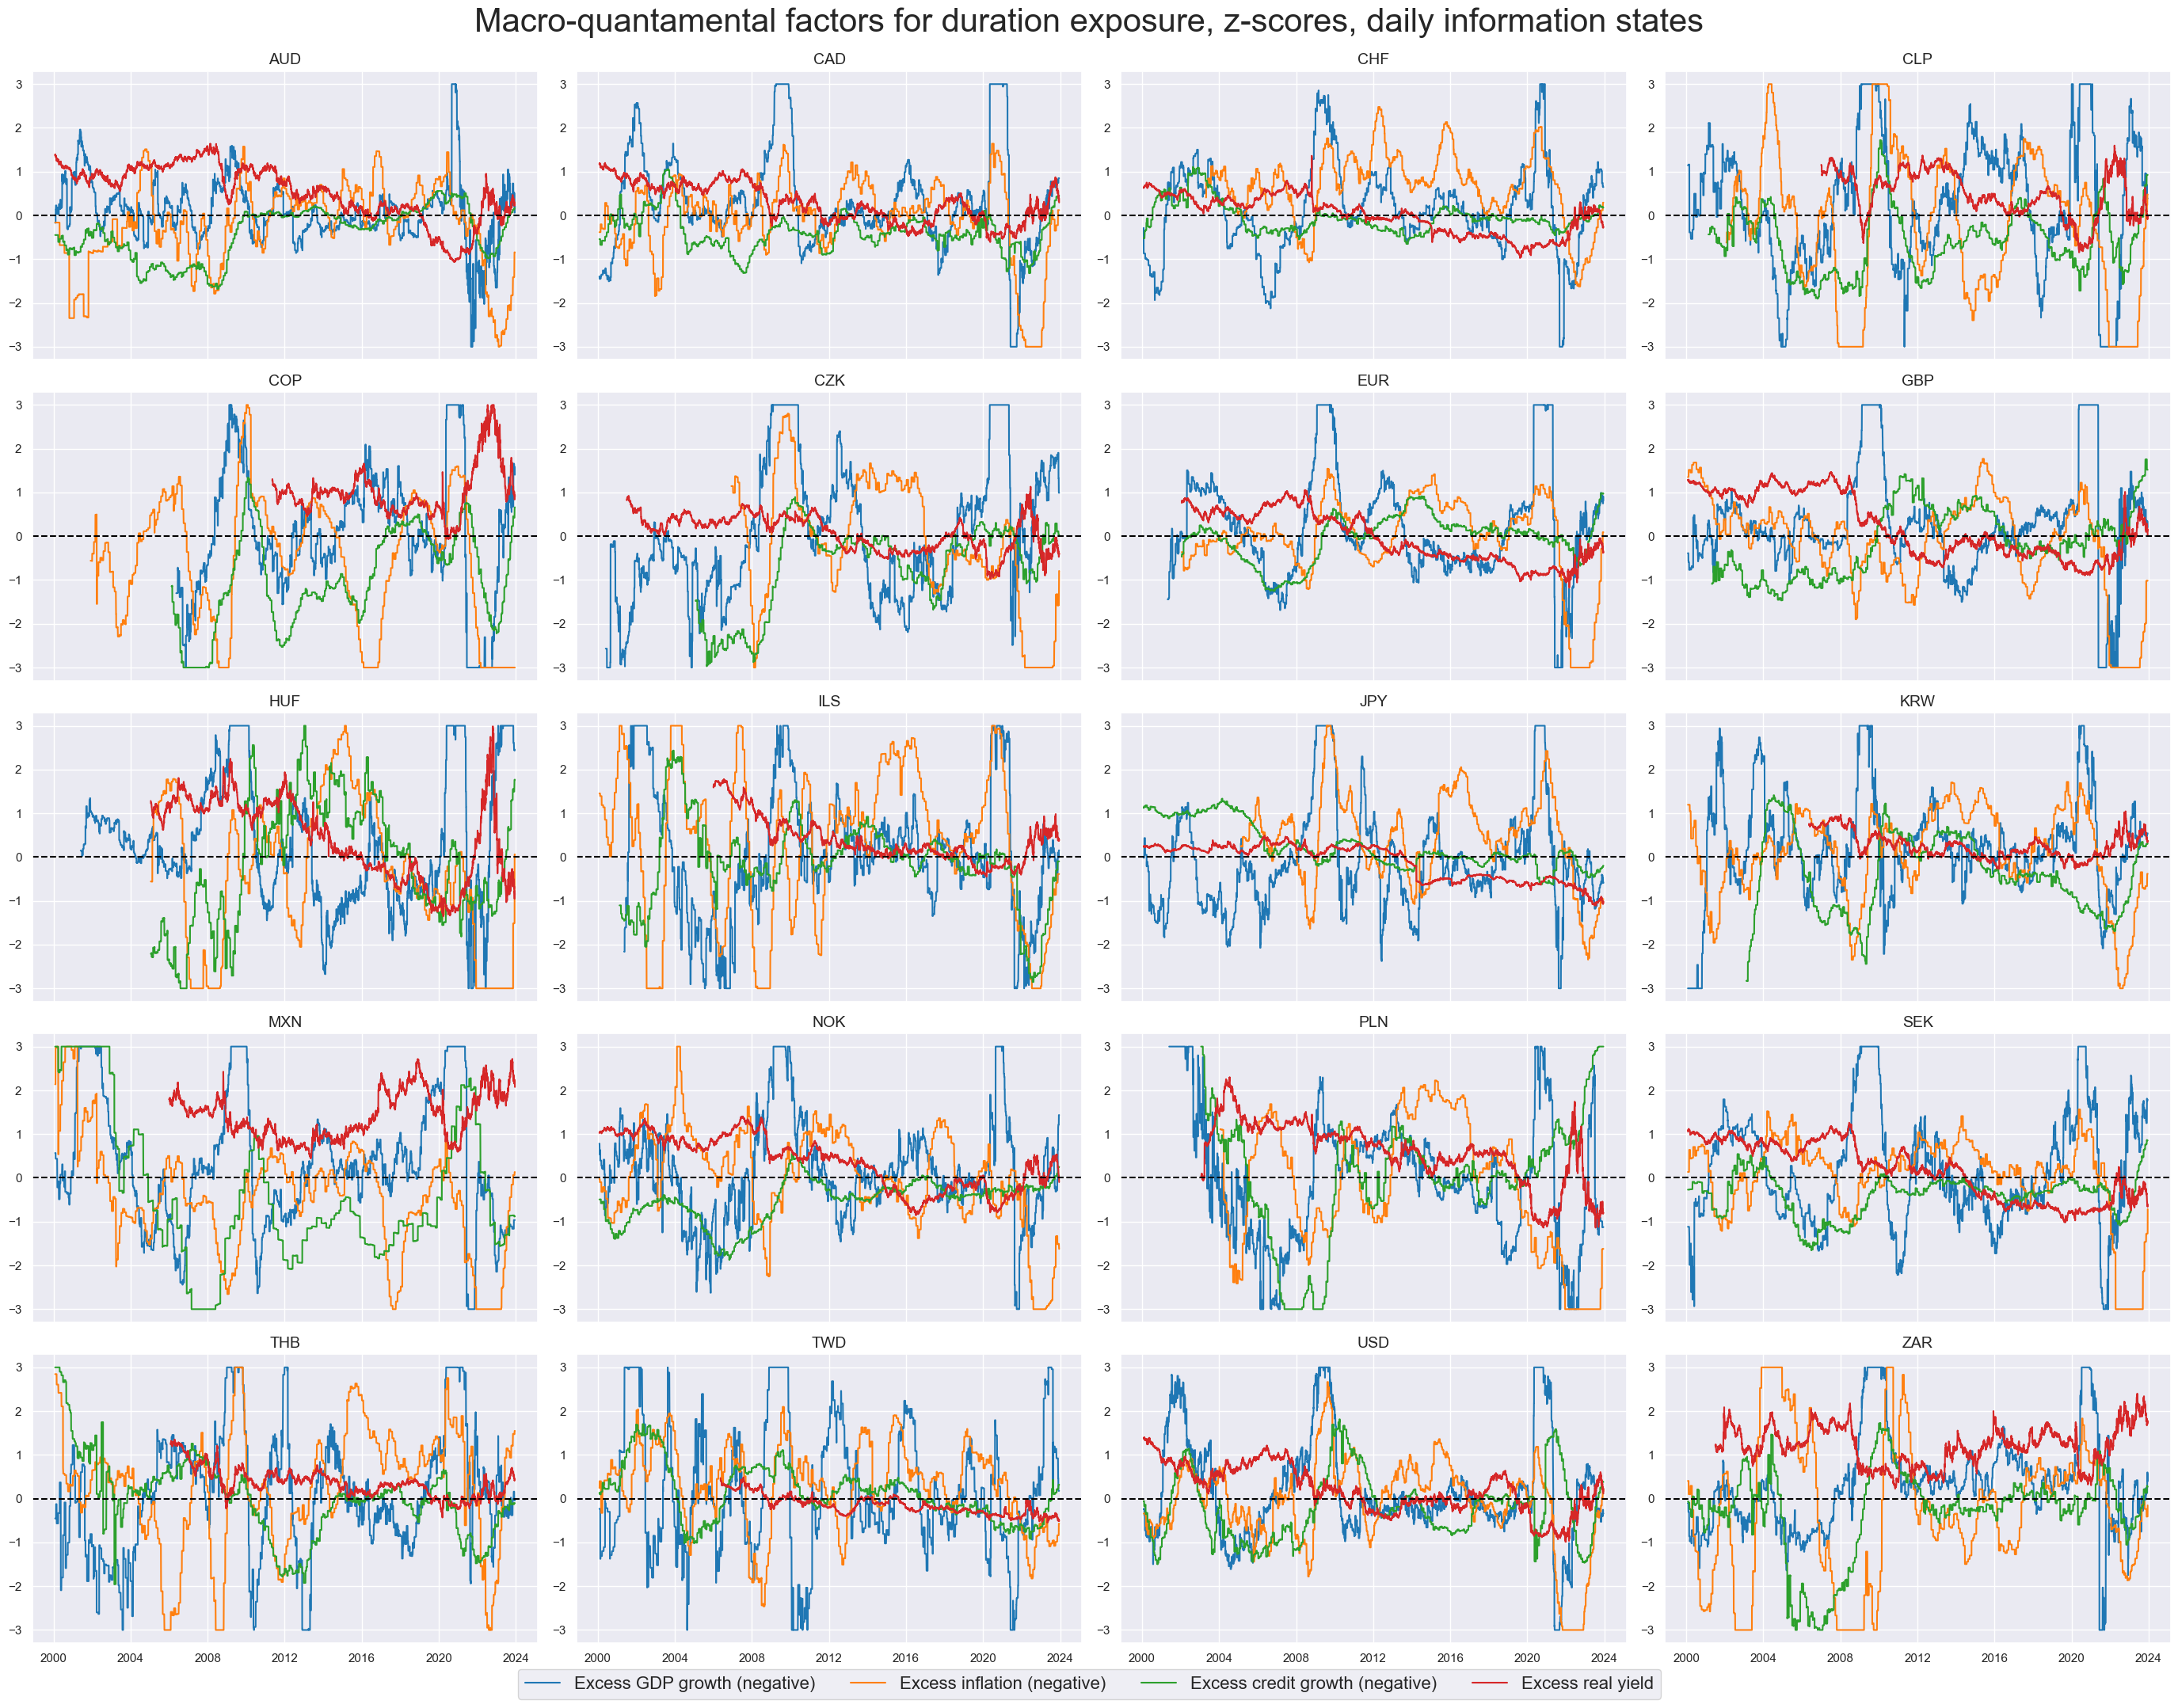

In [17]:
macroz = [m + "_ZN" for m in macros]
xcatx = macroz[:-4]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dux,
    ncol=4,
    start="2000-01-01",
    title="Macro-quantamental factors for duration exposure, z-scores, daily information states",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=[
        "Excess GDP growth (negative)",
        "Excess inflation (negative)",
        "Excess credit growth (negative)",
        "Excess real yield",
    ],
    legend_fontsize=16,
)

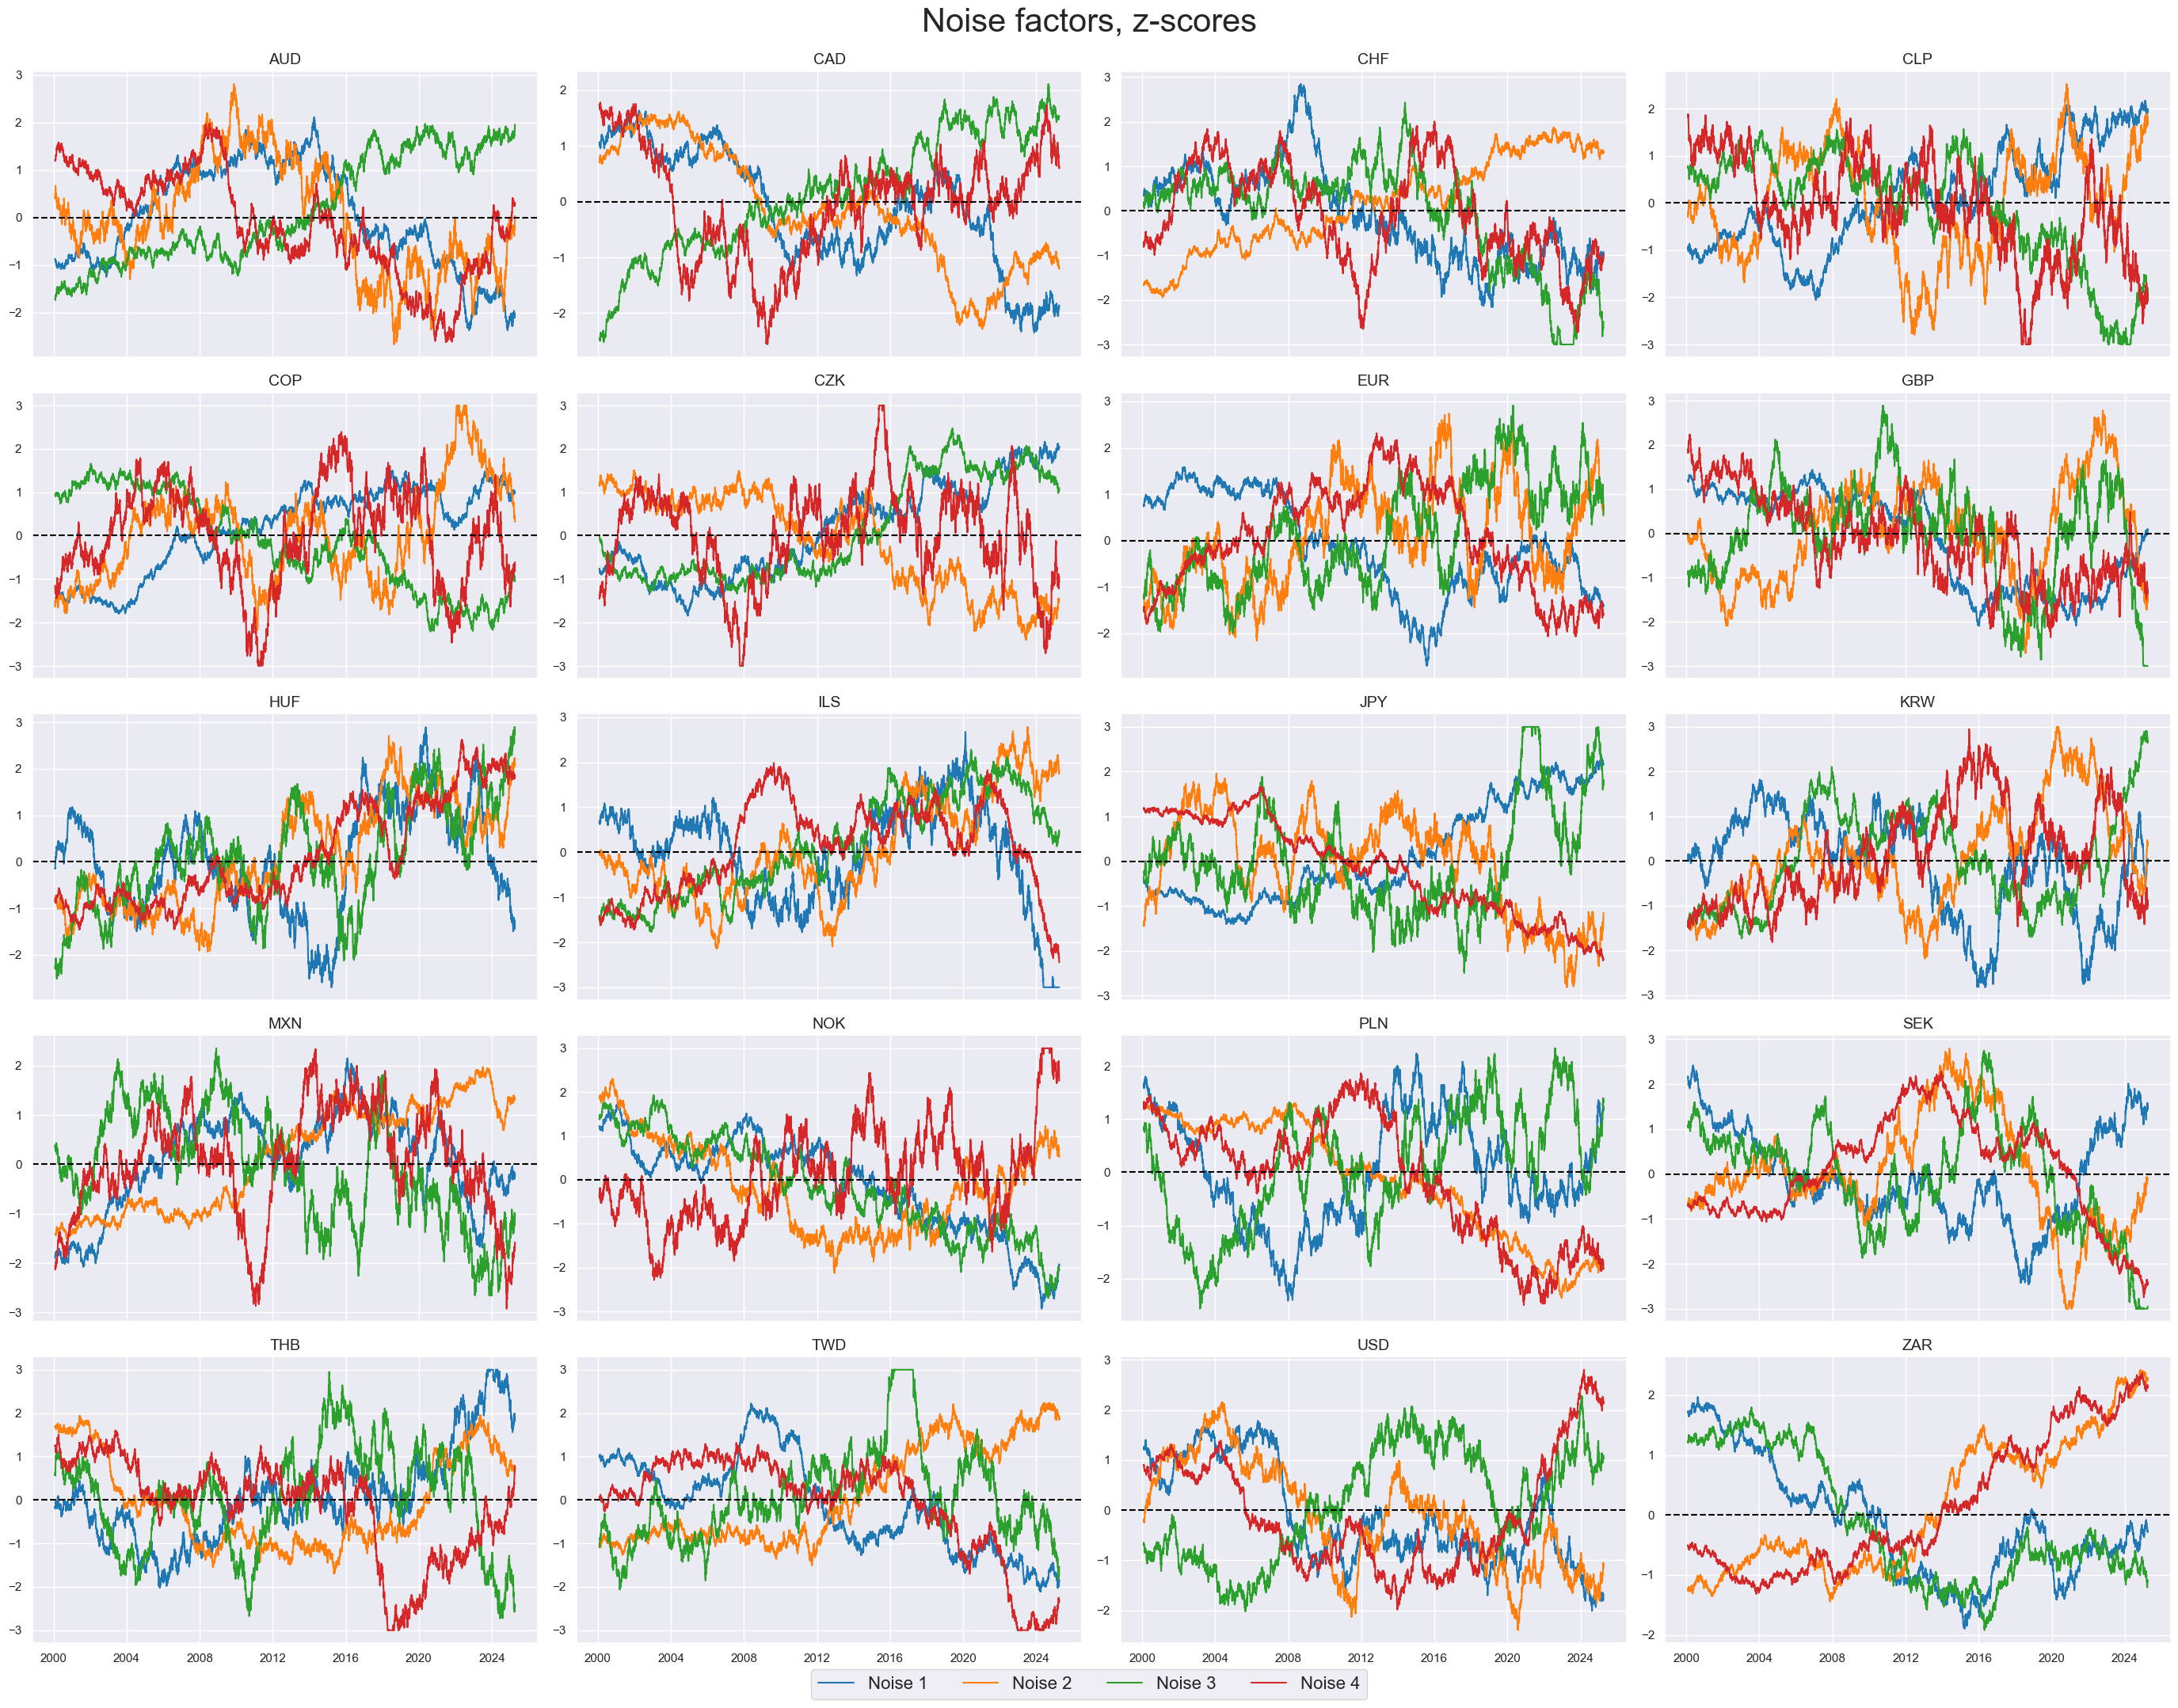

In [18]:
xcatx = macroz[-4:]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dux,
    ncol=4,
    start="2000-01-01",
    title="Noise factors, z-scores",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=["Noise 1", "Noise 2", "Noise 3", "Noise 4"],
    legend_fontsize=16,
)

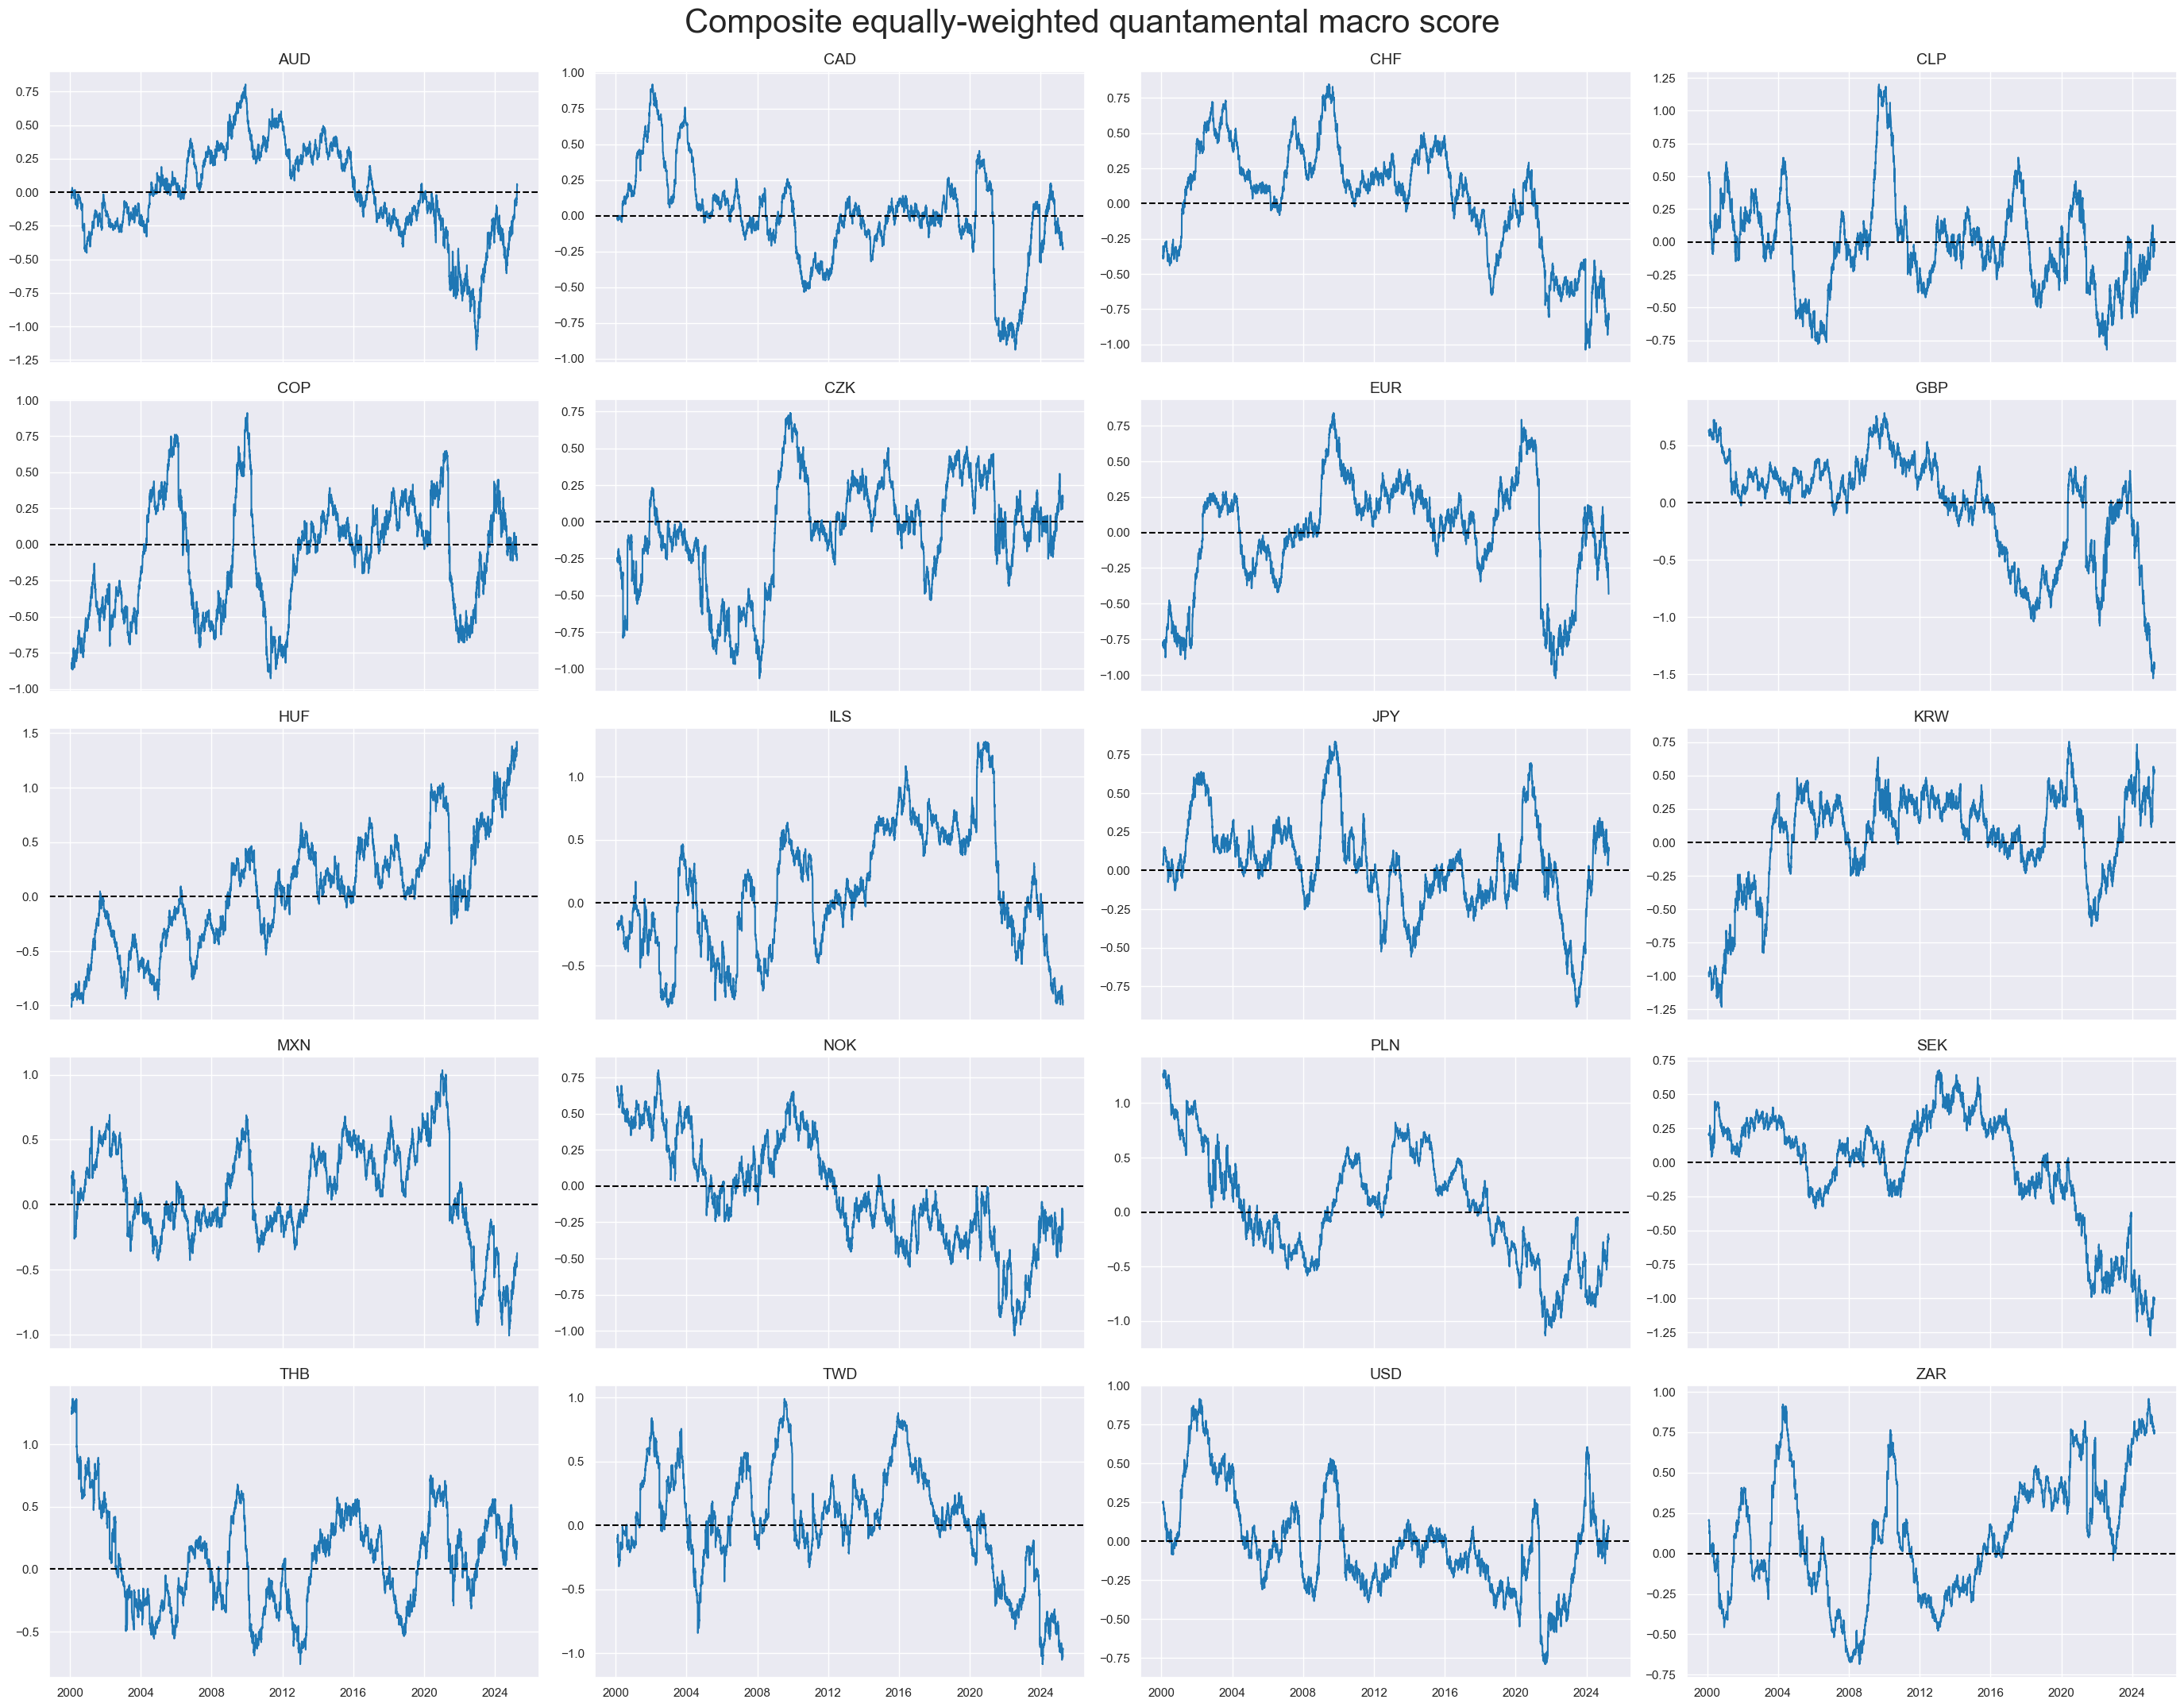

In [19]:
xcatx = ["MACRO_AVGZ"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=sorted(cids_dux),
    ncol=4,
    start="2000-01-01",
    title="Composite equally-weighted quantamental macro score",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=None,
)

### Features and targets for scikit-learn (defunct)

In [20]:
# Specify features and target category
xcatx = macroz + ["DU05YXR_VT10"]

# Downsample from daily to monthly frequency (features as last and target as sum)
dfw = msm.categories_df(
    df=dfx,
    xcats=xcatx,
    cids=cids_dux,
    freq="M",
    lag=1,
    blacklist=fxblack,
    xcat_aggs=["last", "sum"],
)

# Drop rows with missing values and assign features and target
dfw.dropna(inplace=True)
X = dfw.iloc[:, :-1]
y = dfw.iloc[:, -1]

## Cross-validation

### Types of cross-validation

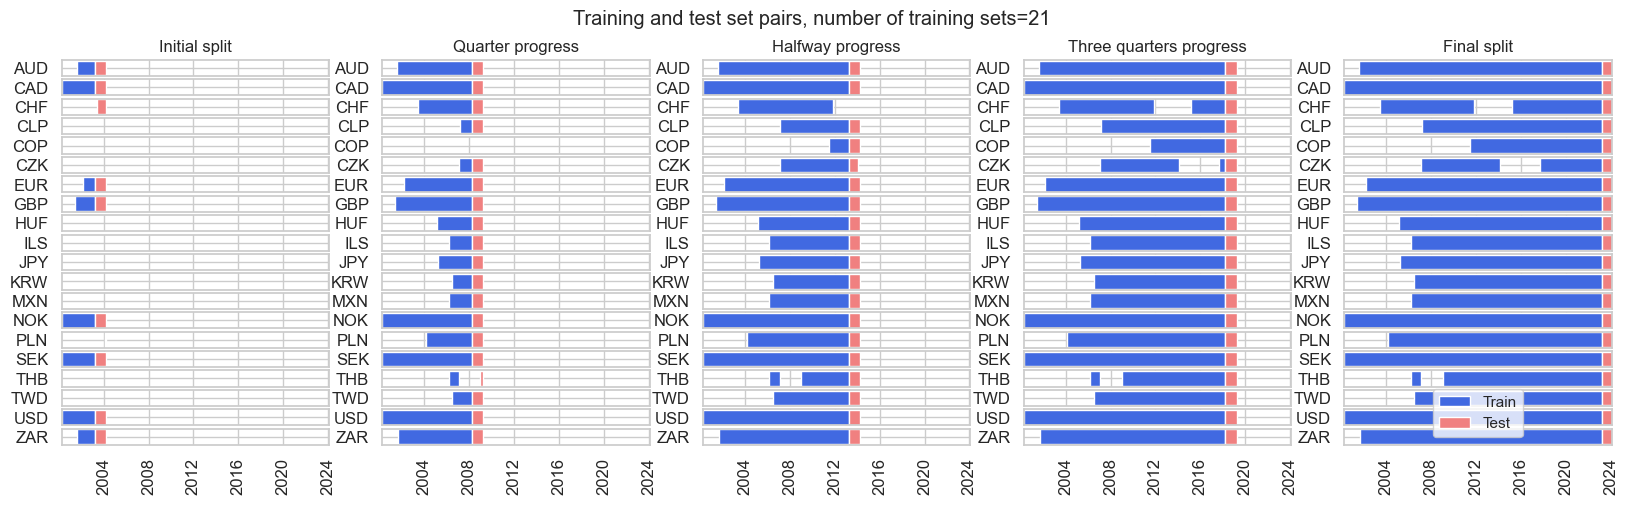

In [21]:
split_xi = msl.ExpandingIncrementPanelSplit(
    train_intervals=12, min_periods=36, test_size=12
)
split_xi.visualise_splits(X, y)

Generally, we will use one of the three below splitters as cross-validation splitters in our research.

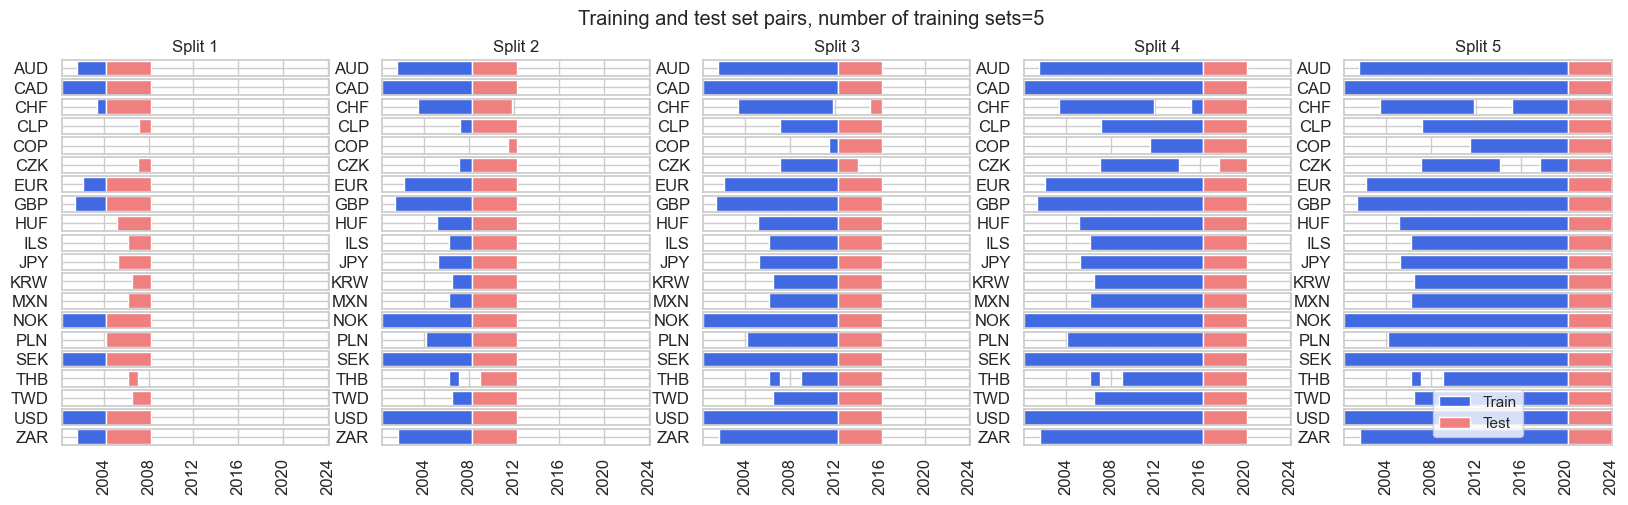

In [22]:
split_xkf = msl.ExpandingKFoldPanelSplit(n_splits=5)
split_xkf.visualise_splits(X, y)

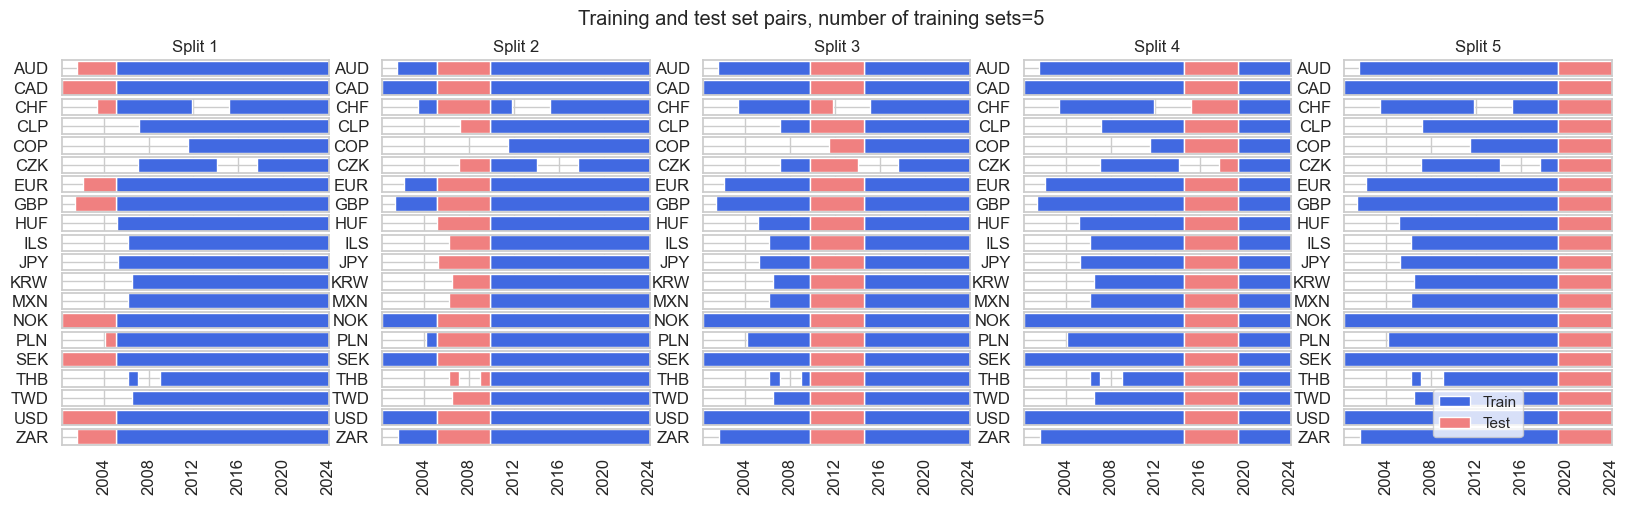

In [23]:
split_rkf = msl.RollingKFoldPanelSplit(n_splits=5)
split_rkf.visualise_splits(X, y)

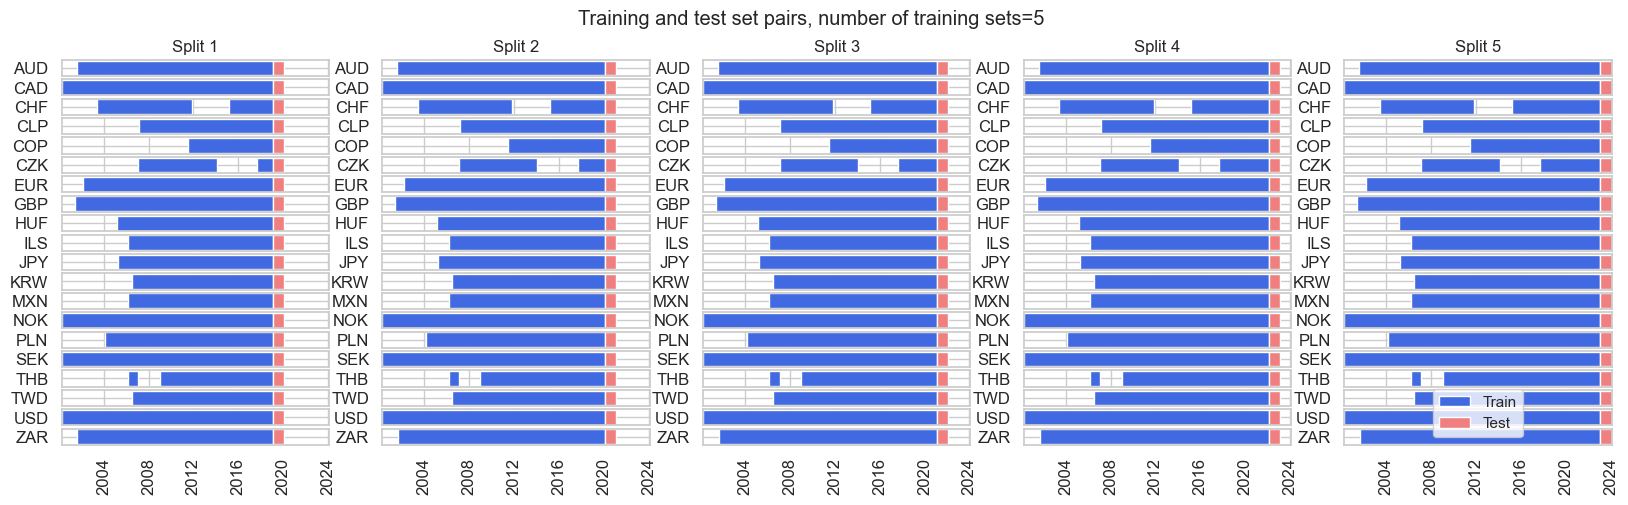

In [24]:
split_rec = msl.RecencyKFoldPanelSplit(n_splits=5, n_periods=12)
split_rec.visualise_splits(X, y)

## Signal generation

In [25]:
min_cids = 4
min_periods = 36
cv_summary = "median"

splitter = {"Rolling": msl.RollingKFoldPanelSplit(5)}

scorer_fs = {"MAP": make_scorer(msl.panel_significance_probability)}
scorer_reg = {"SHARPE": make_scorer(msl.sharpe_ratio)}
scorer_cls = {"BAC": make_scorer(balanced_accuracy_score)}

test_size_rf = 3  # Random forest pipelines
test_size_fs = 1  # Feature selection pipeline

ftrs_renamed = {
    "XGDP_NEG_ZN": "Excess GDP growth (negative)",
    "XCPI_NEG_ZN": "Excess inflation (negative)",
    "XRYLDIRS05Y_NSA_ZN": "Excess real yield",
    "XPCG_NEG_ZN": "Excess credit growth (negative)",
    "NOISE1_ZN": "Noise factor 1",
    "NOISE2_ZN": "Noise factor 2",
    "NOISE3_ZN": "Noise factor 3",
    "NOISE4_ZN": "Noise factor 4",
}

### Feature selection

#### Model pipeline

In [26]:
mods_fsz = {
    "LASSO_Z": Pipeline(
        [
            ("selector", msl.LassoSelector(positive=True)),
            ("predictor", msl.NaiveRegressor()),
        ]
    ),
    "MAP_Z": Pipeline(
        [
            ("selector", msl.MapSelector()),
            ("predictor", msl.NaiveRegressor()),
        ]
    ),
}

grids_fsz = {
    "LASSO_Z": {
        "selector__n_factors": [1, 2, 4, 8],
    },

    "MAP_Z": {
        "selector__n_factors": [1, 2, 4, 8],
    },
}

#### Backtest

In [27]:
xcatx = macroz + ["DU05YXR_VT10"]
cidx = cids_dux

so_fsz = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

so_fsz.calculate_predictions(
    name = "MACRO_OPTSELZ",
    models = mods_fsz,
    hyperparameters = grids_fsz,
    scorers = scorer_fs,
    inner_splitters = splitter,
    min_cids = min_cids,
    min_periods = min_periods,
    cv_summary=cv_summary,
    n_jobs_outer = -1,
)

# Store optimized signals
dfa = so_fsz.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/250 [00:00<?, ?it/s]

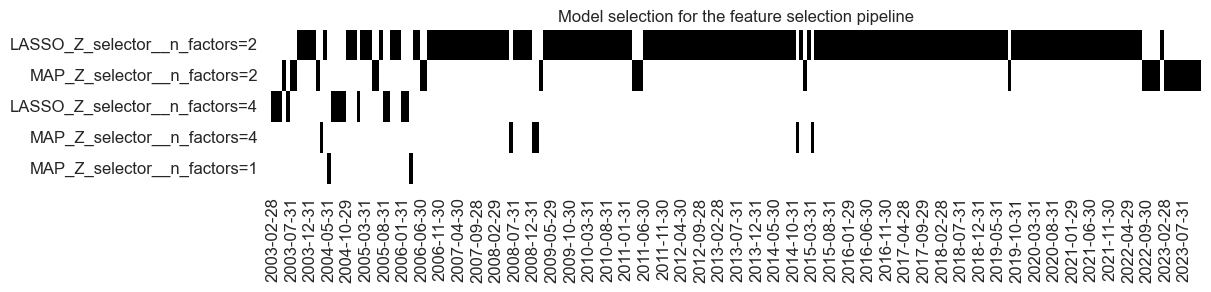

In [28]:
so_fsz.models_heatmap(
    name="MACRO_OPTSELZ",
    cap=6,
    title="Model selection for the feature selection pipeline",
    figsize=(12, 2),
)

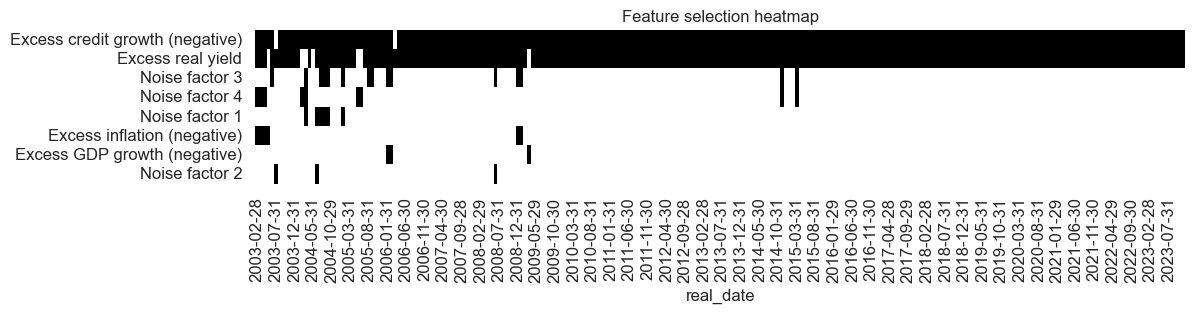

In [29]:
so_fsz.feature_selection_heatmap(
    name="MACRO_OPTSELZ",
    ftrs_renamed={
        "XGDP_NEG_ZN": "Excess GDP growth (negative)",
        "XCPI_NEG_ZN": "Excess inflation (negative)",
        "XRYLDIRS05Y_NSA_ZN": "Excess real yield",
        "XPCG_NEG_ZN": "Excess credit growth (negative)",
        "NOISE1_ZN": "Noise factor 1",
        "NOISE2_ZN": "Noise factor 2",
        "NOISE3_ZN": "Noise factor 3",
        "NOISE4_ZN": "Noise factor 4",
    },
    title = "Feature selection heatmap",
    figsize=(12, 2),
)

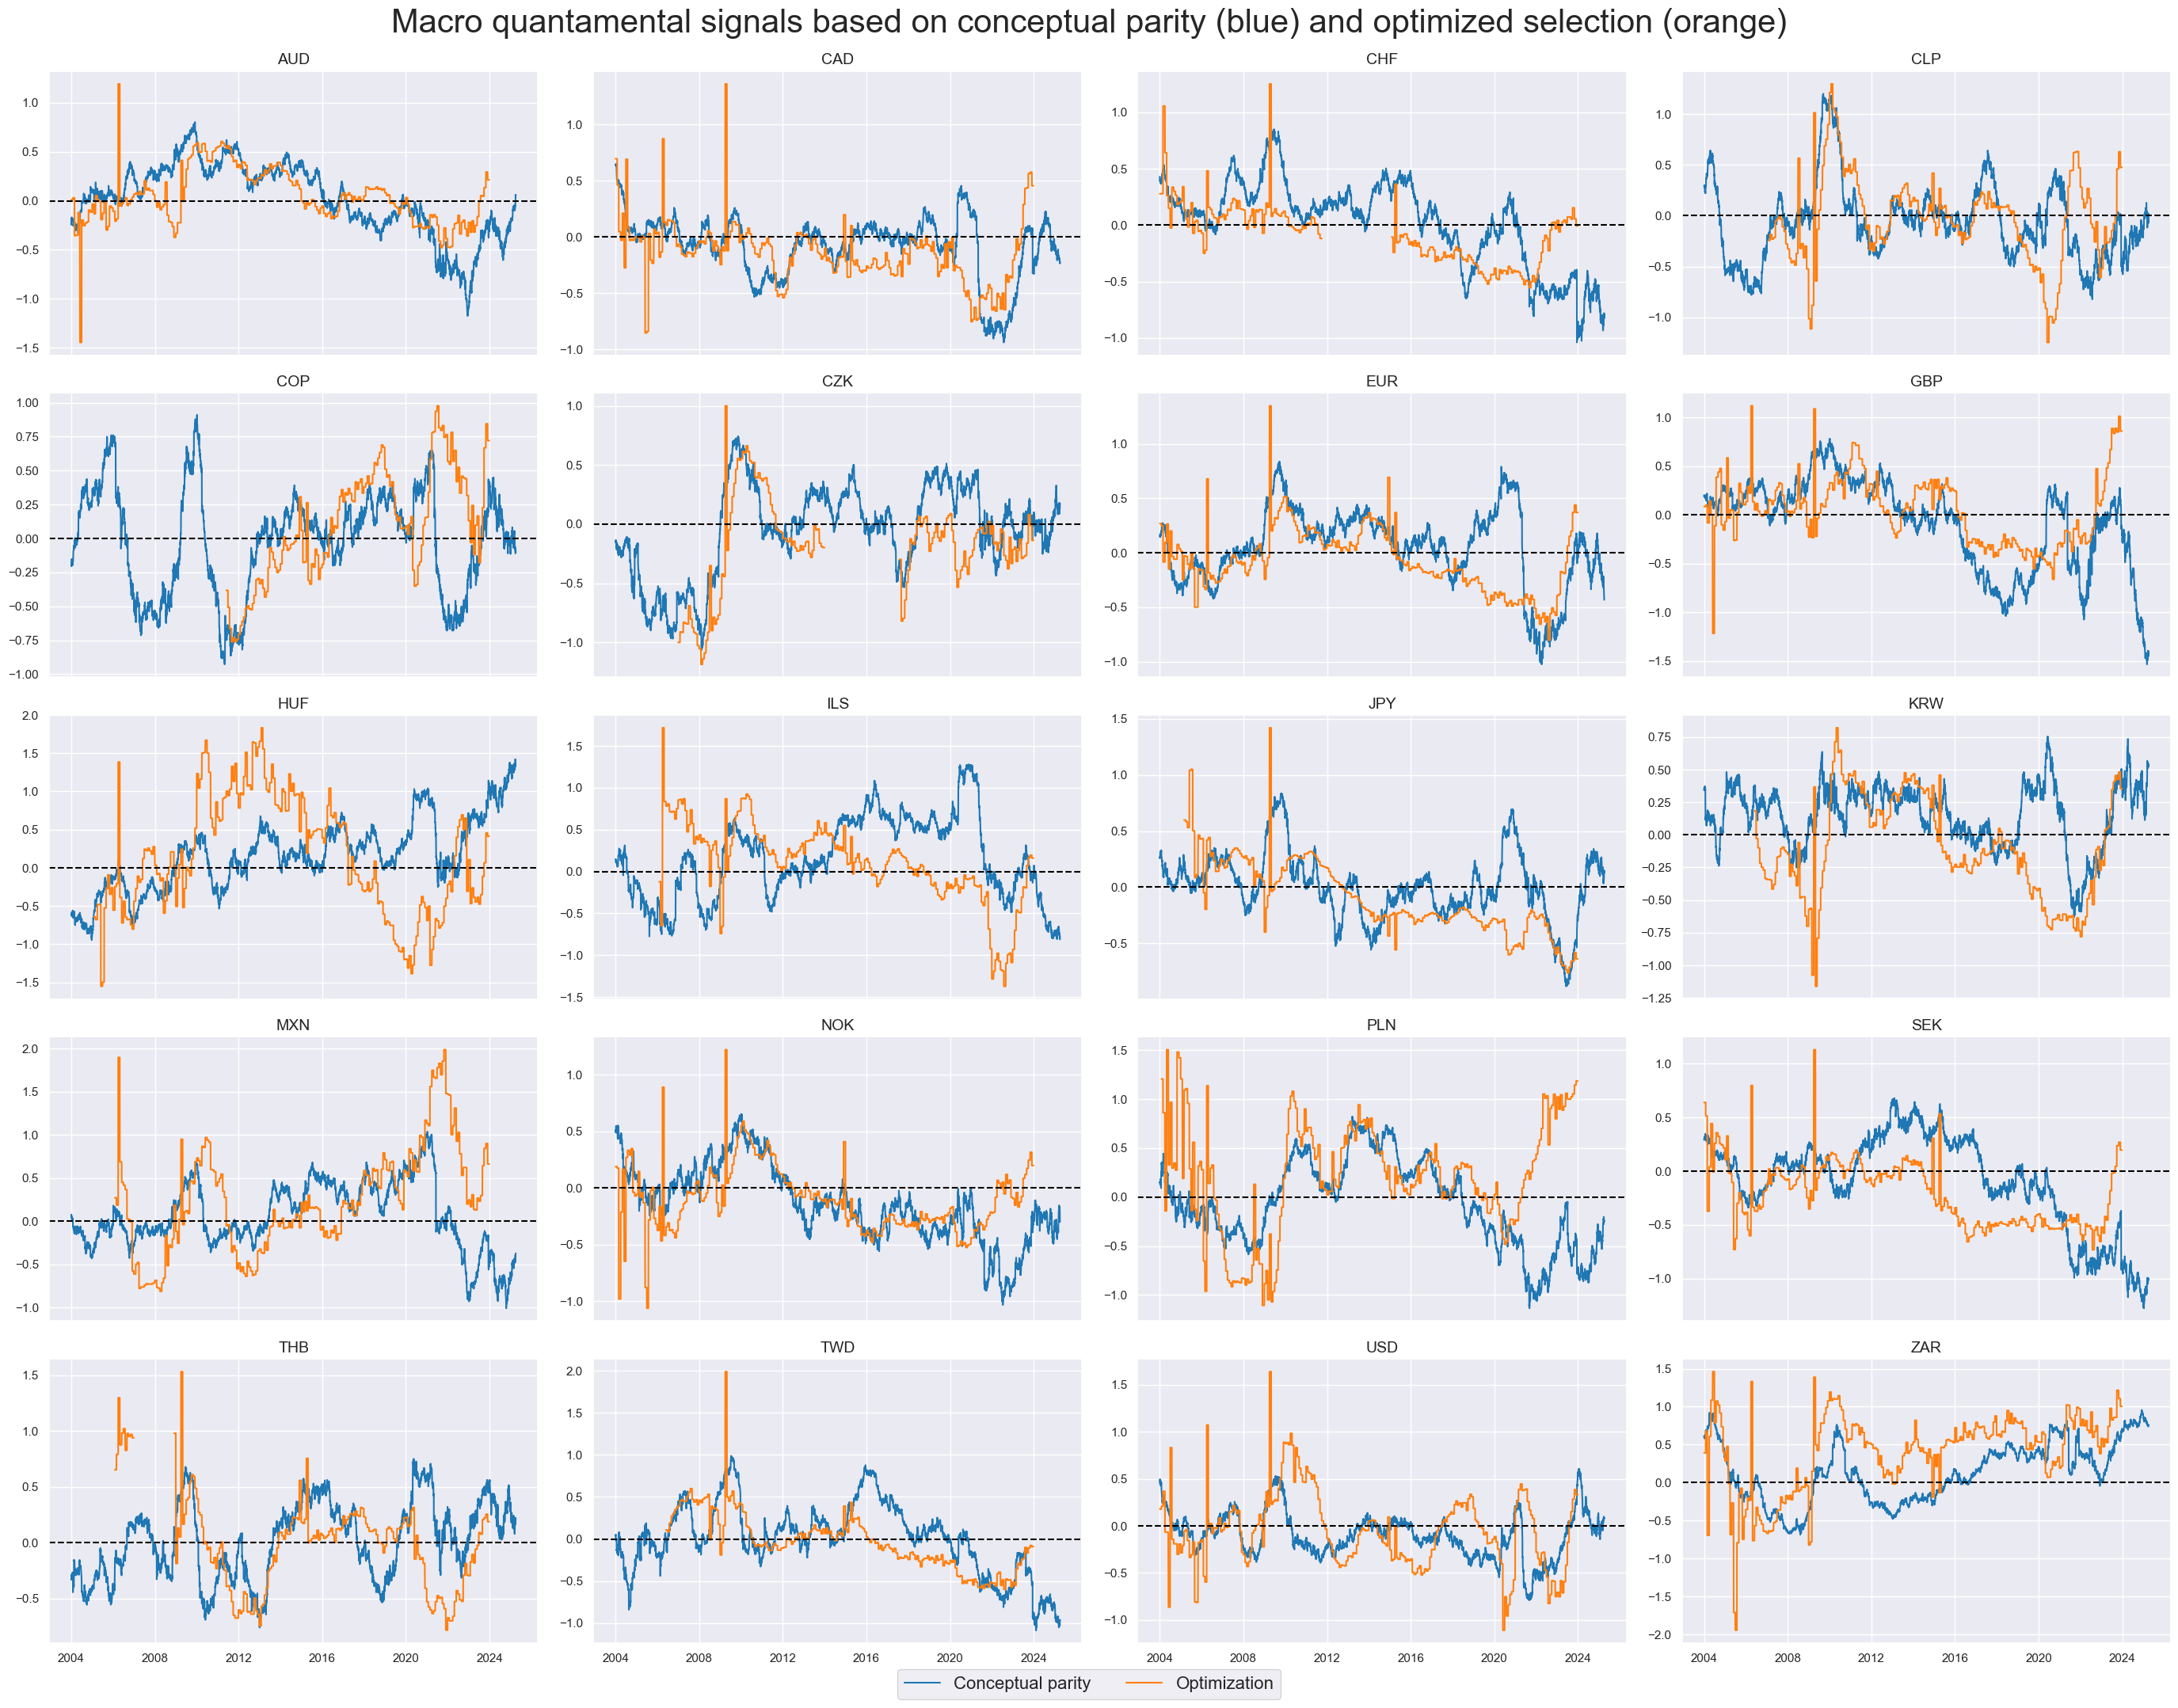

In [30]:
xcatx = ["MACRO_AVGZ", "MACRO_OPTSELZ"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dux,
    ncol=4,
    start="2004-01-01",
    title="Macro quantamental signals based on conceptual parity (blue) and optimized selection (orange)",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=["Conceptual parity", "Optimization"],
    legend_fontsize=16,
)

#### Value checks

In [31]:
## Compare optimized signals with simple average z-scores

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=["DU05YXR_VT10"],
    sigs=["MACRO_AVGZ", "MACRO_OPTSELZ"],
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start="2004-01-01",
    blacklist=fxblack,
    slip=1,
)

tbl_srr = srr.multiple_relations_table()

In [32]:
display(tbl_srr.astype("float").round(3))

accuracy  bal_accuracy  \
Return       Signal        Frequency Aggregation                           
DU05YXR_VT10 MACRO_AVGZ    M         last            0.528         0.524   
             MACRO_OPTSELZ M         last            0.548         0.551   

                                                  pos_sigr  pos_retr  \
Return       Signal        Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ    M         last            0.548      0.54   
             MACRO_OPTSELZ M         last            0.469      0.54   

                                                  pos_prec  neg_prec  pearson  \
Return       Signal        Frequency Aggregation                                
DU05YXR_VT10 MACRO_AVGZ    M         last            0.562     0.487    0.068   
             MACRO_OPTSELZ M         last            0.594     0.508    0.122   

                                                  pearson_pval  kendall  \
Return       Signal        Frequency Aggregation                          
DU05YXR_VT10 MACRO_AVGZ    M         last                  0.0    0.045   
             MACRO_OPTSELZ M         last                  0.0    0.087   

                                                  kendall_pval    auc  
Return       Signal        Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ    M         last                  0.0  0.524  
             MACRO_OPTSELZ M         last                  0.0  0.551

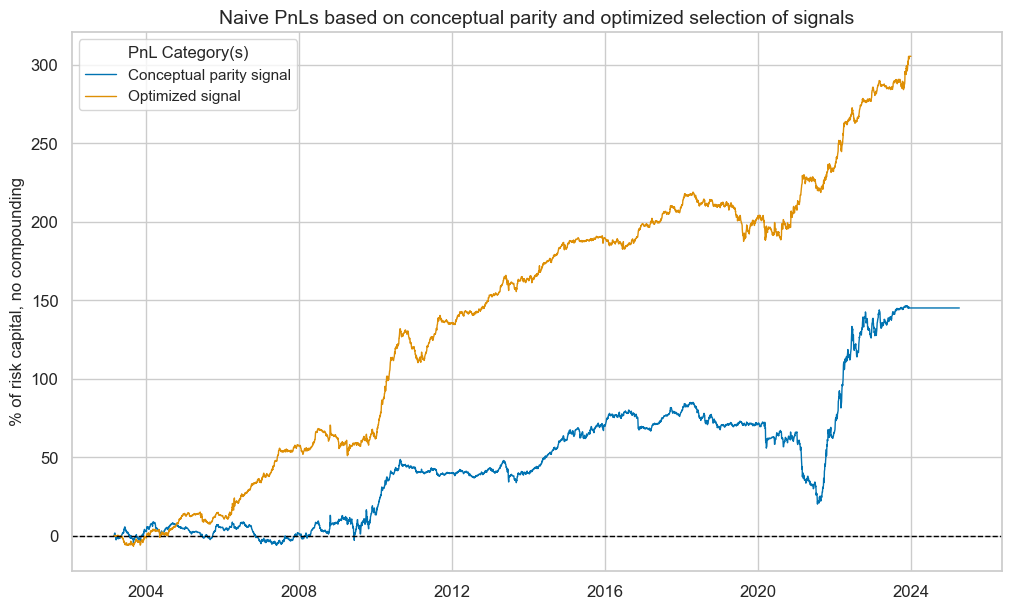

In [33]:
sigs = ["MACRO_AVGZ", "MACRO_OPTSELZ"]


pnl = msn.NaivePnL(
    df=dfx,
    ret="DU05YXR_VT10",
    sigs=sigs,
    cids=cids_dux,
    start="2003-02-28",
    blacklist=fxblack,
    bms="USD_DU05YXR_NSA",
)
for sig in sigs:
    pnl.make_pnl(
        sig=sig,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
        thresh=3,
    )


pnl.plot_pnls(
    title="Naive PnLs based on conceptual parity and optimized selection of signals",
    title_fontsize=14,
    xcat_labels=["Conceptual parity signal", "Optimized signal"],
)
pcats = ["PNL_" + sig for sig in sigs]

In [34]:
pnl.evaluate_pnls(pnl_cats=pcats)

xcat                     PNL_MACRO_AVGZ PNL_MACRO_OPTSELZ
Return %                       6.567574         14.666097
St. Dev. %                         10.0              10.0
Sharpe Ratio                   0.656757           1.46661
Sortino Ratio                  0.948005          2.345387
Max 21-Day Draw %            -23.226711         -14.41805
Max 6-Month Draw %           -40.518375        -23.566145
Peak to Trough Draw %        -64.857082        -31.359033
Top 5% Monthly PnL Share       1.121147          0.487168
USD_DU05YXR_NSA correl        -0.055771         -0.050112
Traded Months                       267               267

### Regression forecasts

#### Model pipeline

In [35]:
from sklearn.base import BaseEstimator, MetaEstimatorMixin, RegressorMixin

class FIExtractor(BaseEstimator, MetaEstimatorMixin, RegressorMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.estimator.fit(X, y)
        
        if hasattr(self.estimator, "coef_"):
            self.feature_importances_ = np.abs(self.estimator.coef_) / np.sum(np.abs(self.estimator.coef_))
        elif hasattr(self.estimator, "feature_importances_"):
            self.feature_importances_ = self.estimator.feature_importances_ / np.sum(self.estimator.feature_importances_)
            
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
        
    def __getattr__(self, attr):
        """
        Get attributes from the underlying model.
        """
        if hasattr(self.estimator, attr):
            return getattr(self.estimator, attr)
        
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

In [36]:
mods_reg = {
    "linreg": FIExtractor(LinearRegression(positive=True)),
    "rf": FIExtractor(
            RandomForestRegressor(
                max_features = 0.3,
                min_samples_leaf = 5,
                n_estimators = 500,
                monotonic_cst = [1,1,1,1,1,1,1,1],
                random_state = 42
            )
    )
}

grids_reg = {
    "linreg": {"estimator__fit_intercept": [True, False]},
    "rf": {"estimator__max_samples": [0.1, 0.5]},
}

#### Backtest

In [37]:
xcatx = macroz + ["DU05YXR_VT10"]
cidx = cids_dux

so_reg = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=fxblack,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
)

so_reg.calculate_predictions(
    name="MACRO_OPTREG",
    models=mods_reg,
    hyperparameters=grids_reg,
    scorers=scorer_reg,
    inner_splitters=splitter,
    search_type="grid",
    normalize_fold_results=False,
    cv_summary=cv_summary,
    min_cids=min_cids,
    min_periods=min_periods,
    test_size=test_size_rf,
    n_jobs_outer=-1,
)

dfa = so_reg.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/84 [00:00<?, ?it/s]

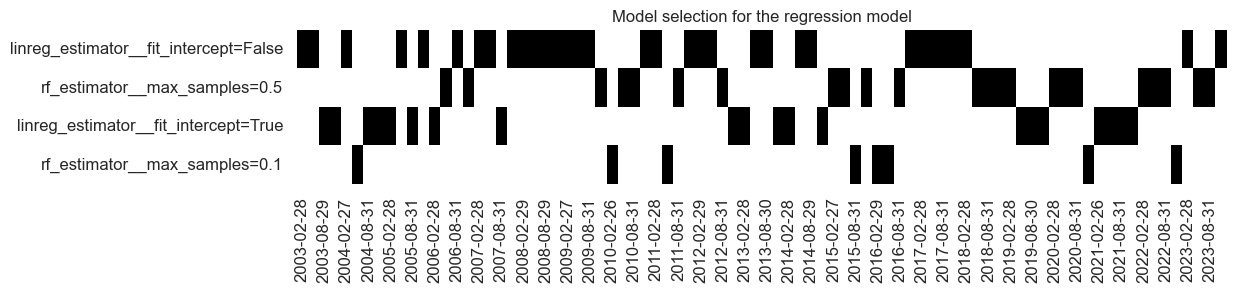

In [38]:
so_reg.models_heatmap(
    name="MACRO_OPTREG",
    cap=6,
    title="Model selection for the regression model",
    figsize=(12, 2),
)

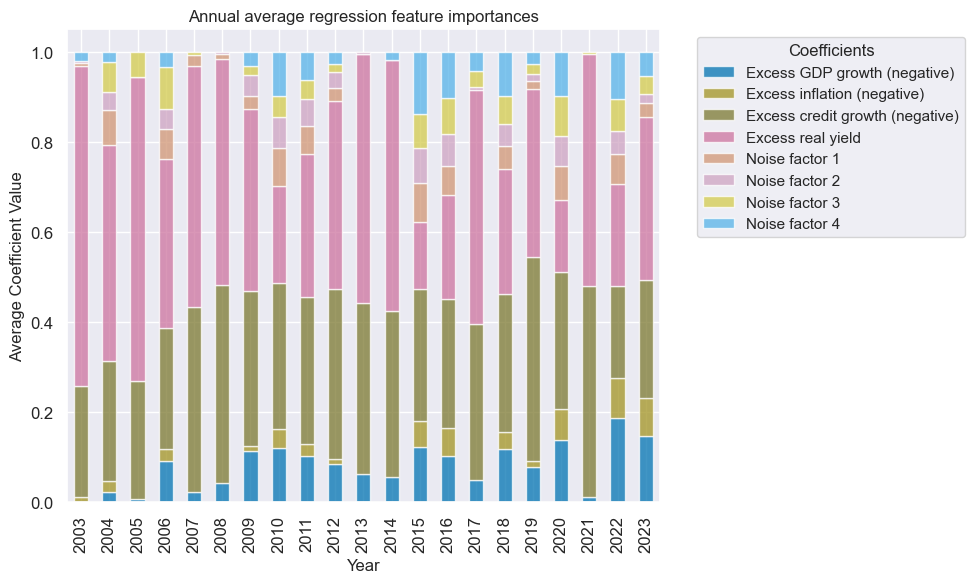

In [39]:
so_reg.coefs_stackedbarplot(name="MACRO_OPTREG", ftrs_renamed=ftrs_renamed, title="Annual average regression feature importances")

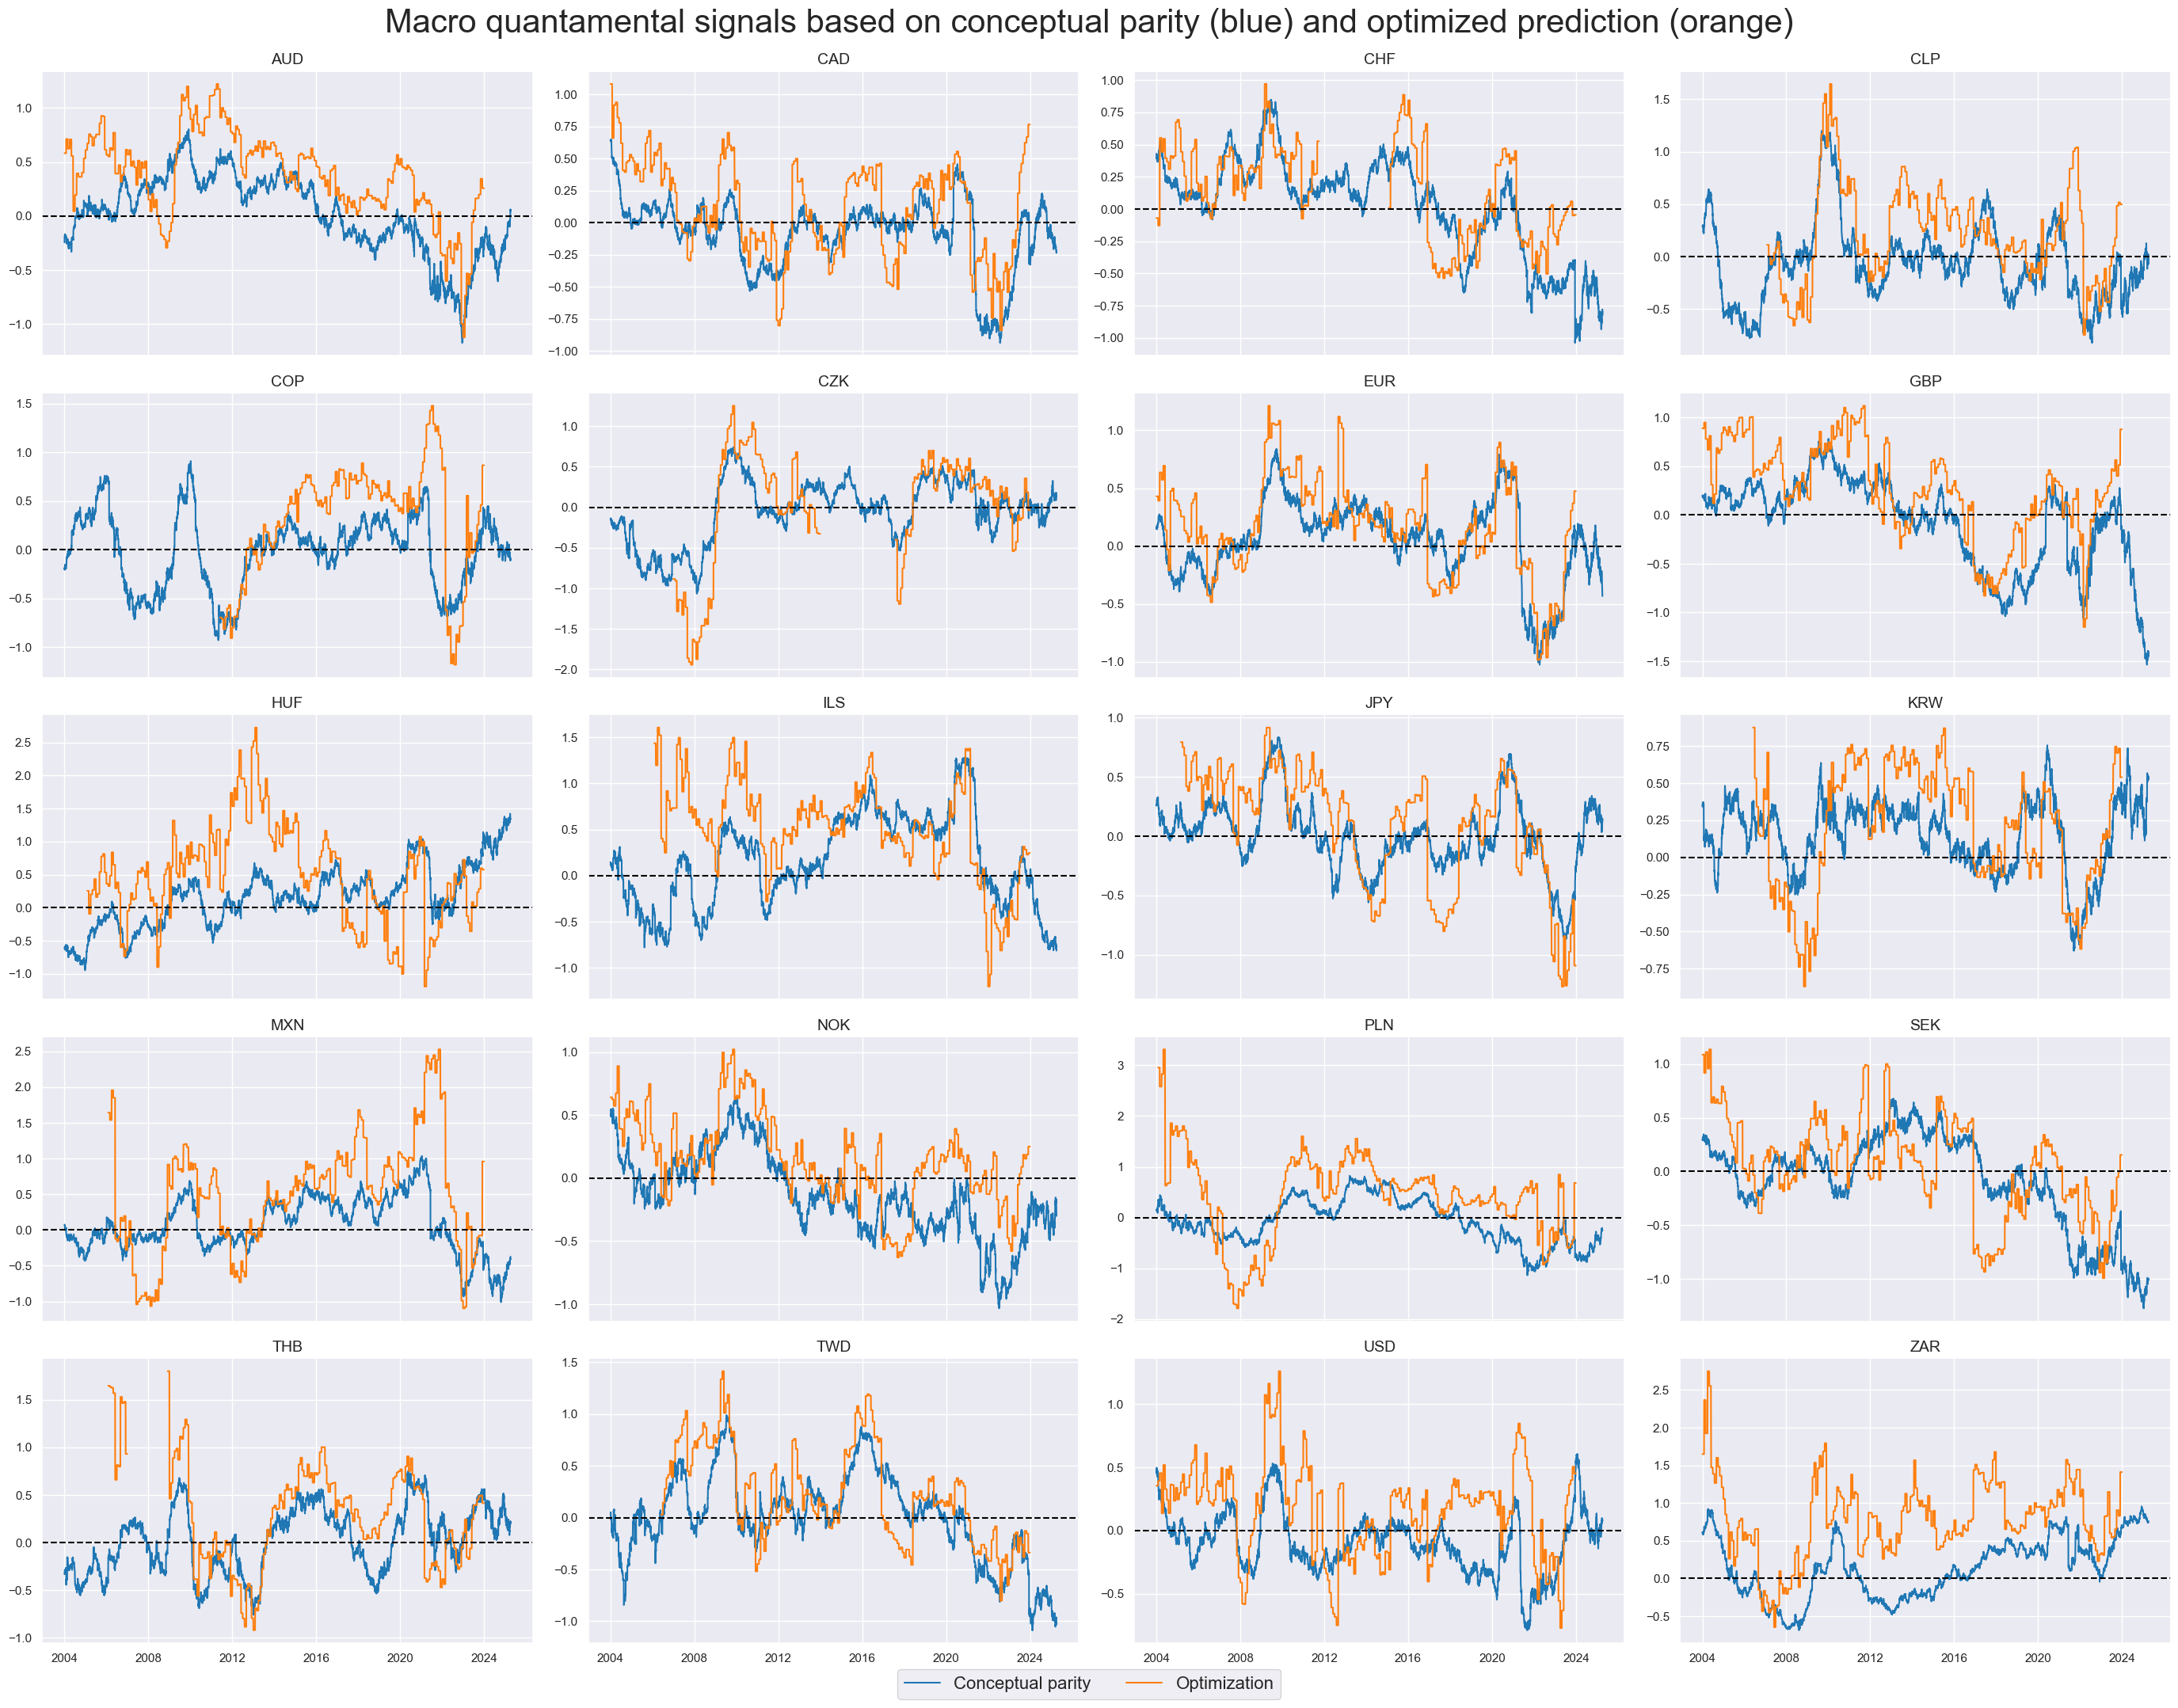

In [40]:
xcatx = ["MACRO_AVGZ", "MACRO_OPTREG"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dux,
    ncol=4,
    start="2004-01-01",
    title="Macro quantamental signals based on conceptual parity (blue) and optimized prediction (orange)",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=["Conceptual parity", "Optimization"],
    legend_fontsize=16,
)

#### Value checks

In [41]:
srr = mss.SignalReturnRelations(
    df=dfx,
    rets=["DU05YXR_VT10"],
    sigs=["MACRO_AVGZ", "MACRO_OPTREG"],
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start="2004-01-01",
    blacklist=fxblack,
    slip=1,
)

tbl_srr = srr.signals_table()

In [42]:
display(tbl_srr.astype("float").round(3))

accuracy  bal_accuracy  \
Return       Signal       Frequency Aggregation                           
DU05YXR_VT10 MACRO_AVGZ   M         last            0.528         0.524   
             MACRO_OPTREG M         last            0.541         0.529   

                                                 pos_sigr  pos_retr  pos_prec  \
Return       Signal       Frequency Aggregation                                 
DU05YXR_VT10 MACRO_AVGZ   M         last            0.548      0.54     0.562   
             MACRO_OPTREG M         last            0.720      0.54     0.556   

                                                 neg_prec  pearson  \
Return       Signal       Frequency Aggregation                      
DU05YXR_VT10 MACRO_AVGZ   M         last            0.487    0.068   
             MACRO_OPTREG M         last            0.501    0.077   

                                                 pearson_pval  kendall  \
Return       Signal       Frequency Aggregation                          
DU05YXR_VT10 MACRO_AVGZ   M         last                  0.0    0.045   
             MACRO_OPTREG M         last                  0.0    0.047   

                                                 kendall_pval    auc  
Return       Signal       Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ   M         last                  0.0  0.524  
             MACRO_OPTREG M         last                  0.0  0.523

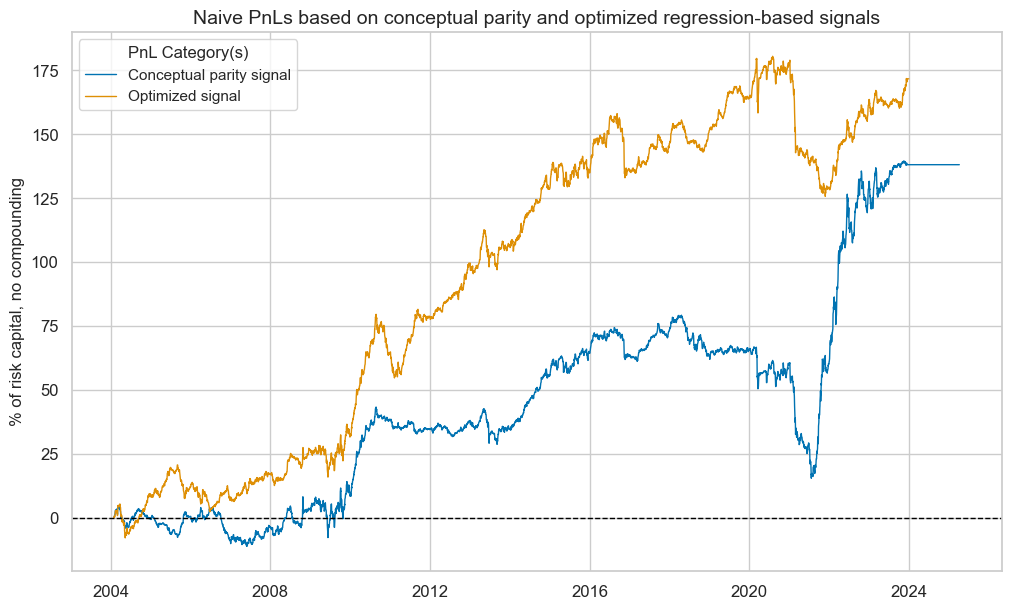

In [43]:
sigs = ["MACRO_AVGZ", "MACRO_OPTREG"]


pnl = msn.NaivePnL(
    df=dfx,
    ret="DU05YXR_VT10",
    sigs=sigs,
    cids=cids_dux,
    start="2004-01-01",
    blacklist=fxblack,
)
for sig in sigs:
    pnl.make_pnl(
        sig=sig,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
        thresh=3,
    )

pnl.plot_pnls(
    title="Naive PnLs based on conceptual parity and optimized regression-based signals",
    title_fontsize=14,
    xcat_labels=["Conceptual parity signal", "Optimized signal"],
)
pcats = ["PNL_" + sig for sig in sigs]

In [44]:
pnl.evaluate_pnls(pnl_cats=pcats)

xcat                     PNL_MACRO_AVGZ PNL_MACRO_OPTREG
Return %                         6.5219         8.620469
St. Dev. %                         10.0             10.0
Sharpe Ratio                    0.65219         0.862047
Sortino Ratio                  0.940523         1.225309
Max 21-Day Draw %            -22.790474       -30.378276
Max 6-Month Draw %           -39.781846       -39.507975
Peak to Trough Draw %        -63.771069       -54.804725
Top 5% Monthly PnL Share       1.108347         0.643585
Traded Months                       256              256

### Classification

In [45]:
ys = np.sign(y)
calcs = ["MACRO_AVGZ_SIGN = np.sign( MACRO_AVGZ )"]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

#### Model pipeline

In [46]:
mods_cls = {
    "logreg": FIExtractor(LogisticRegression()),
    "rf": FIExtractor(
            RandomForestClassifier(
                max_features=0.3,  # Default suggested in Breiman's original paper
                min_samples_leaf=1,  # Default suggested in Breiman's original paper for classification
                n_estimators=500,  # Default suggested in Breiman's original paper
                monotonic_cst=[1, 1, 1, 1, 1, 1, 1, 1],
                random_state=42,
            ),
        ),
}

grids_cls = {
    "logreg": {
        "estimator__fit_intercept": [True, False],
    },
    "rf": {
        "estimator__max_samples": [0.1, 0.5]
    }
}

In [47]:
xcatx = macroz + ["DU05YXR_VT10"]
cidx = cids_dux

so_cls = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=fxblack,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    generate_labels=lambda x: 1 if x >= 0 else -1,
)

so_cls.calculate_predictions(
    name="MACRO_OPTCLASS",
    models=mods_cls,
    hyperparameters=grids_cls,
    scorers=scorer_cls,
    inner_splitters=splitter,
    search_type="grid",
    normalize_fold_results=False,
    cv_summary=cv_summary,
    min_cids=min_cids,
    min_periods=min_periods,
    test_size=test_size_rf,
    n_jobs_outer=-1,
)

dfa = so_cls.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/84 [00:00<?, ?it/s]

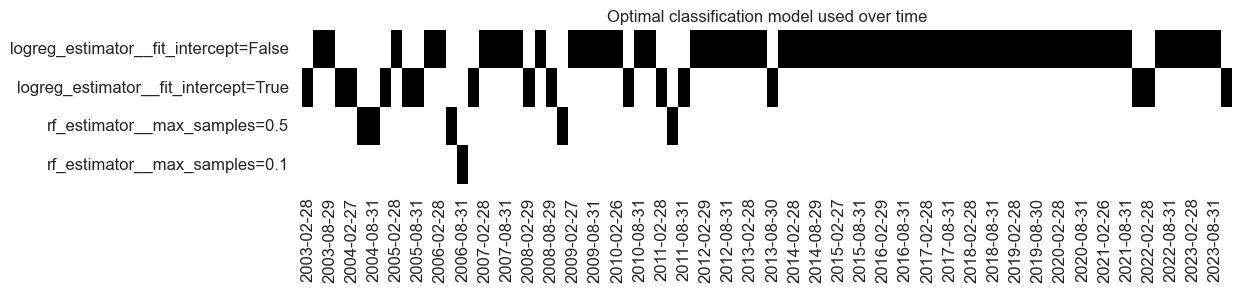

In [48]:
# Get optimized signals and view models heatmap
dfa = so_cls.get_optimized_signals()
so_cls.models_heatmap(
    name="MACRO_OPTCLASS",
    cap=6,
    title="Optimal classification model used over time",
    figsize=(12, 2),
)

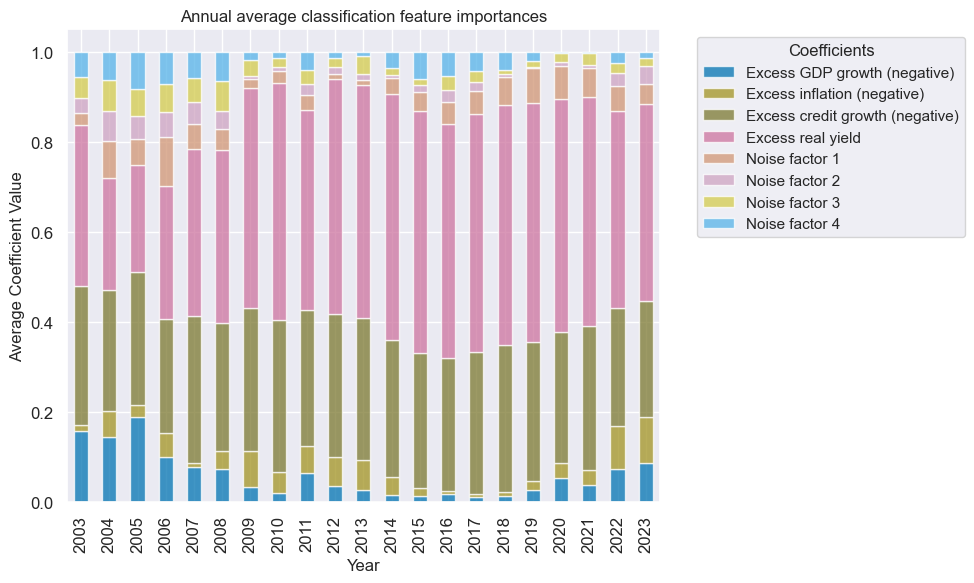

In [49]:
so_cls.coefs_stackedbarplot(name="MACRO_OPTCLASS", ftrs_renamed=ftrs_renamed, title = "Annual average classification feature importances")

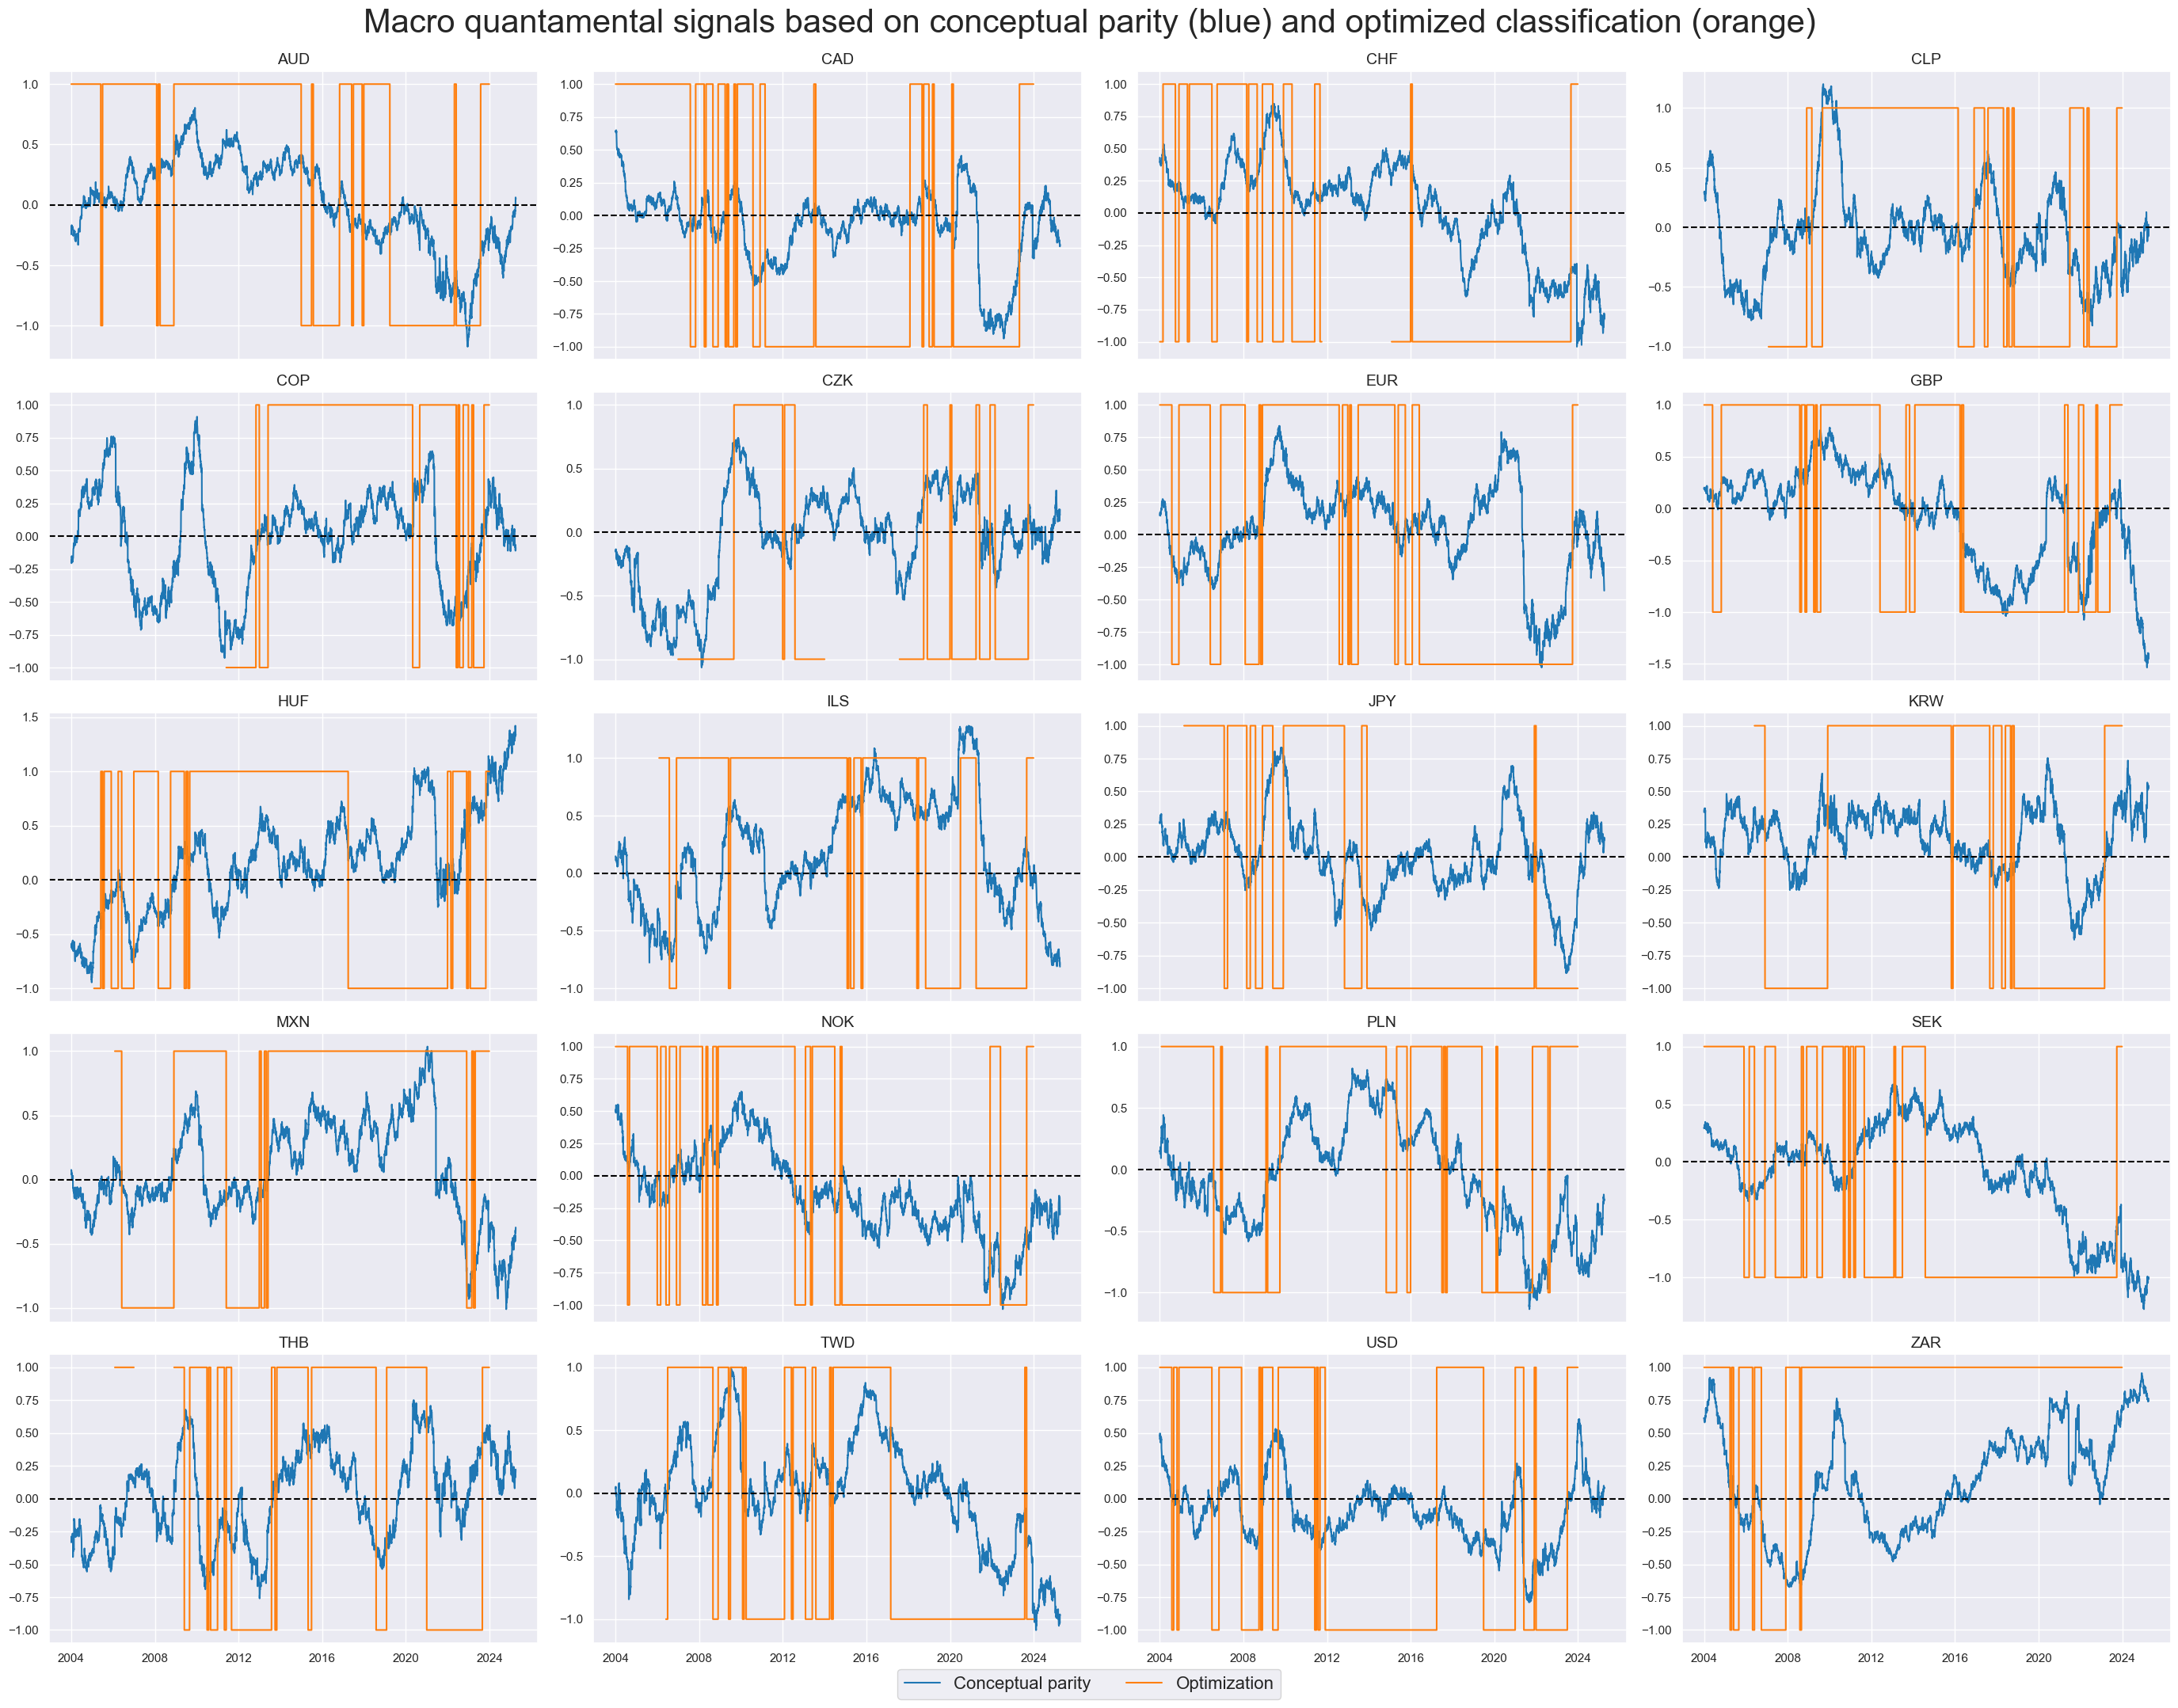

In [50]:
xcatx = ["MACRO_AVGZ", "MACRO_OPTCLASS"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dux,
    ncol=4,
    start="2004-01-01",
    title="Macro quantamental signals based on conceptual parity (blue) and optimized classification (orange)",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=["Conceptual parity", "Optimization"],
    legend_fontsize=16,
)

#### Value checks

In [51]:
## Compare optimized signals with simple average z-scores

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=["DU05YXR_VT10"],
    sigs=["MACRO_AVGZ", "MACRO_OPTCLASS"],
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start="2004-01-01",
    blacklist=fxblack,
    slip=1,
)

tbl_srr = srr.signals_table()

In [52]:
display(tbl_srr.astype("float").round(3))

accuracy  bal_accuracy  \
Return       Signal         Frequency Aggregation                           
DU05YXR_VT10 MACRO_AVGZ     M         last            0.528         0.524   
             MACRO_OPTCLASS M         last            0.534         0.531   

                                                   pos_sigr  pos_retr  \
Return       Signal         Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ     M         last            0.548      0.54   
             MACRO_OPTCLASS M         last            0.544      0.54   

                                                   pos_prec  neg_prec  \
Return       Signal         Frequency Aggregation                       
DU05YXR_VT10 MACRO_AVGZ     M         last            0.562     0.487   
             MACRO_OPTCLASS M         last            0.568     0.493   

                                                   pearson  pearson_pval  \
Return       Signal         Frequency Aggregation                          
DU05YXR_VT10 MACRO_AVGZ     M         last           0.068           0.0   
             MACRO_OPTCLASS M         last           0.084           0.0   

                                                   kendall  kendall_pval  \
Return       Signal         Frequency Aggregation                          
DU05YXR_VT10 MACRO_AVGZ     M         last           0.045           0.0   
             MACRO_OPTCLASS M         last           0.064           0.0   

                                                     auc  
Return       Signal         Frequency Aggregation         
DU05YXR_VT10 MACRO_AVGZ     M         last         0.524  
             MACRO_OPTCLASS M         last         0.531

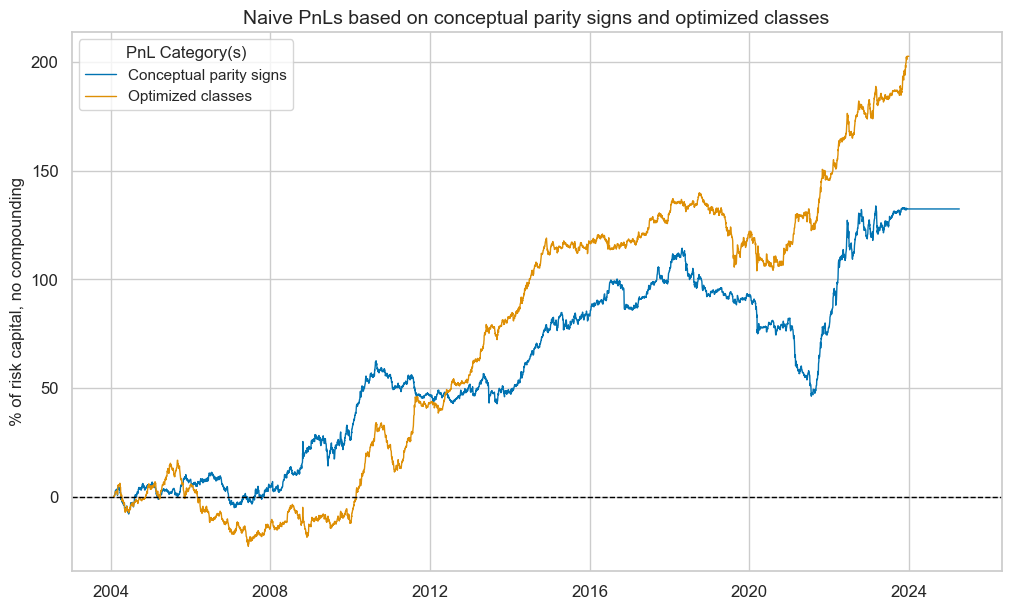

In [53]:
sigs = ["MACRO_AVGZ", "MACRO_OPTCLASS"]


pnl = msn.NaivePnL(
    df=dfx,
    ret="DU05YXR_VT10",
    sigs=sigs,
    cids=cids_dux,
    start="2004-01-01",
    blacklist=fxblack,
)
for sig in sigs:
    pnl.make_pnl(
        sig=sig,
        sig_op="binary",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale = 10
    )

pnl.plot_pnls(
    title="Naive PnLs based on conceptual parity signs and optimized classes",
    title_fontsize=14,
    xcat_labels=["Conceptual parity signs", "Optimized classes"],
)
pcats = ["PNL_" + sig for sig in sigs]

In [54]:
pnl.evaluate_pnls(pnl_cats=pcats)

xcat                     PNL_MACRO_AVGZ PNL_MACRO_OPTCLASS
Return %                       6.253229          10.175289
St. Dev. %                         10.0               10.0
Sharpe Ratio                   0.625323           1.017529
Sortino Ratio                  0.882211           1.578212
Max 21-Day Draw %            -18.151518         -16.376043
Max 6-Month Draw %            -32.02603         -26.033752
Peak to Trough Draw %        -68.078661         -39.574721
Top 5% Monthly PnL Share       0.933957           0.637433
Traded Months                       256                256

## Signal comparison

USD_GB10YXR_NSA has no observations in the DataFrame.


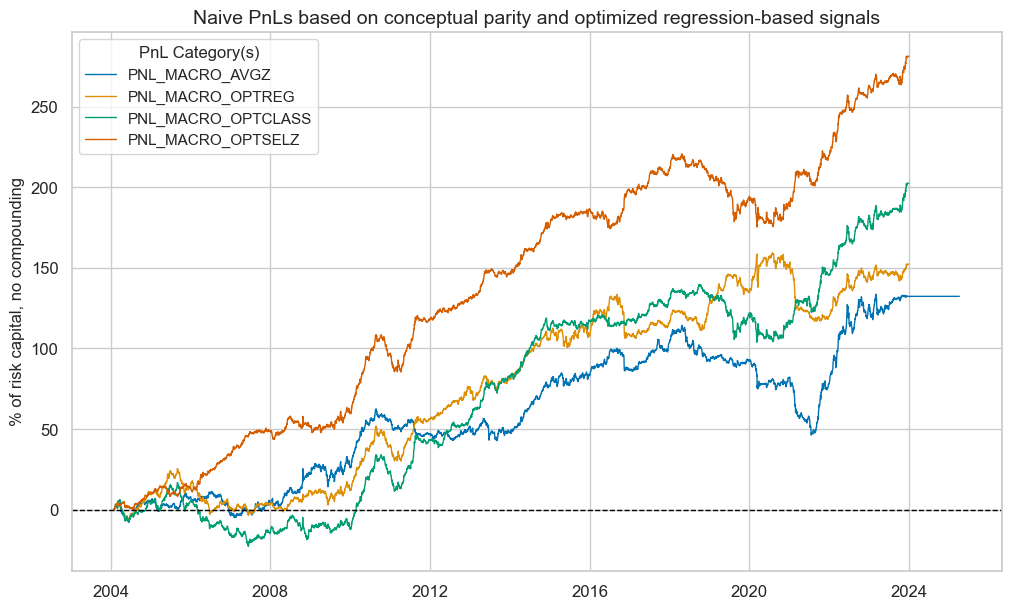

In [55]:
sigs = ["MACRO_AVGZ", "MACRO_OPTREG", "MACRO_OPTCLASS", "MACRO_OPTSELZ"]


pnl = msn.NaivePnL(
    df=dfx,
    ret="DU05YXR_VT10",
    sigs=sigs,
    cids=cids_dux,
    start="2004-01-01",
    blacklist=fxblack,
    bms="USD_GB10YXR_NSA",
)
for sig in sigs:
    pnl.make_pnl(
        sig=sig,
        sig_op="binary",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
        thresh=3,
    )

pnl.plot_pnls(
    title="Naive PnLs based on conceptual parity and optimized regression-based signals",
    title_fontsize=14,
    #xcat_labels=["Conceptual parity signal", "Optimized signal"],
)
pcats = ["PNL_" + sig for sig in sigs]